# Quantum Error Mitigation Best Practices

In this lab we'll be delving into Quantum Error Mitigation (QEM), an important range of techniques for getting the best results out of today's noisy quantum computers. Participants will grasp the essentials of running a program on a quantum computer, how the results may be affected by device errors, and the different techniques available for mitigating those errors. Participants will use the Qiskit SDK and Qiskit Runtime to run an error mitigated quantum program on an IBM quantum computer.


## Requirements

Before starting this tutorial, ensure that you have the following installed:

* Qiskit SDK 1.0 or later with visualization support (`pip install 'qiskit[visualization]'`)
* Qiskit Runtime 0.22 or later (`pip install qiskit-ibm-runtime`)

## Introduction to Qiskit

In this lab we will be using the Qiskit SDK and Qiskit Runtime to build our quantum program and execute it on an IBM quantum computer.

### The Qiskit SDK
The Qiskit SDK (package name qiskit(opens in a new tab)) is an open-source SDK for working with quantum computers at the level of extended (static, dynamic, and scheduled) quantum circuits, operators, and primitives. This library is the core component of Qiskit; it is the largest package under the Qiskit name with the broadest suite of tools for quantum computation, and many other components interface with it.

### Qiskit Runtime

Qiskit Runtime is a cloud-based quantum computing service developed by IBM. It offers computational primitives to perform foundational quantum computing tasks that use built-in error suppression and mitigation techniques. Primitives can be executed inside of sessions, allowing collections of circuits to be jointly run on a quantum computer without being interrupted by other users’ jobs. The combination of primitives, error suppression / mitigation, and sessions paves the way to efficiently build and execute scalable quantum applications.


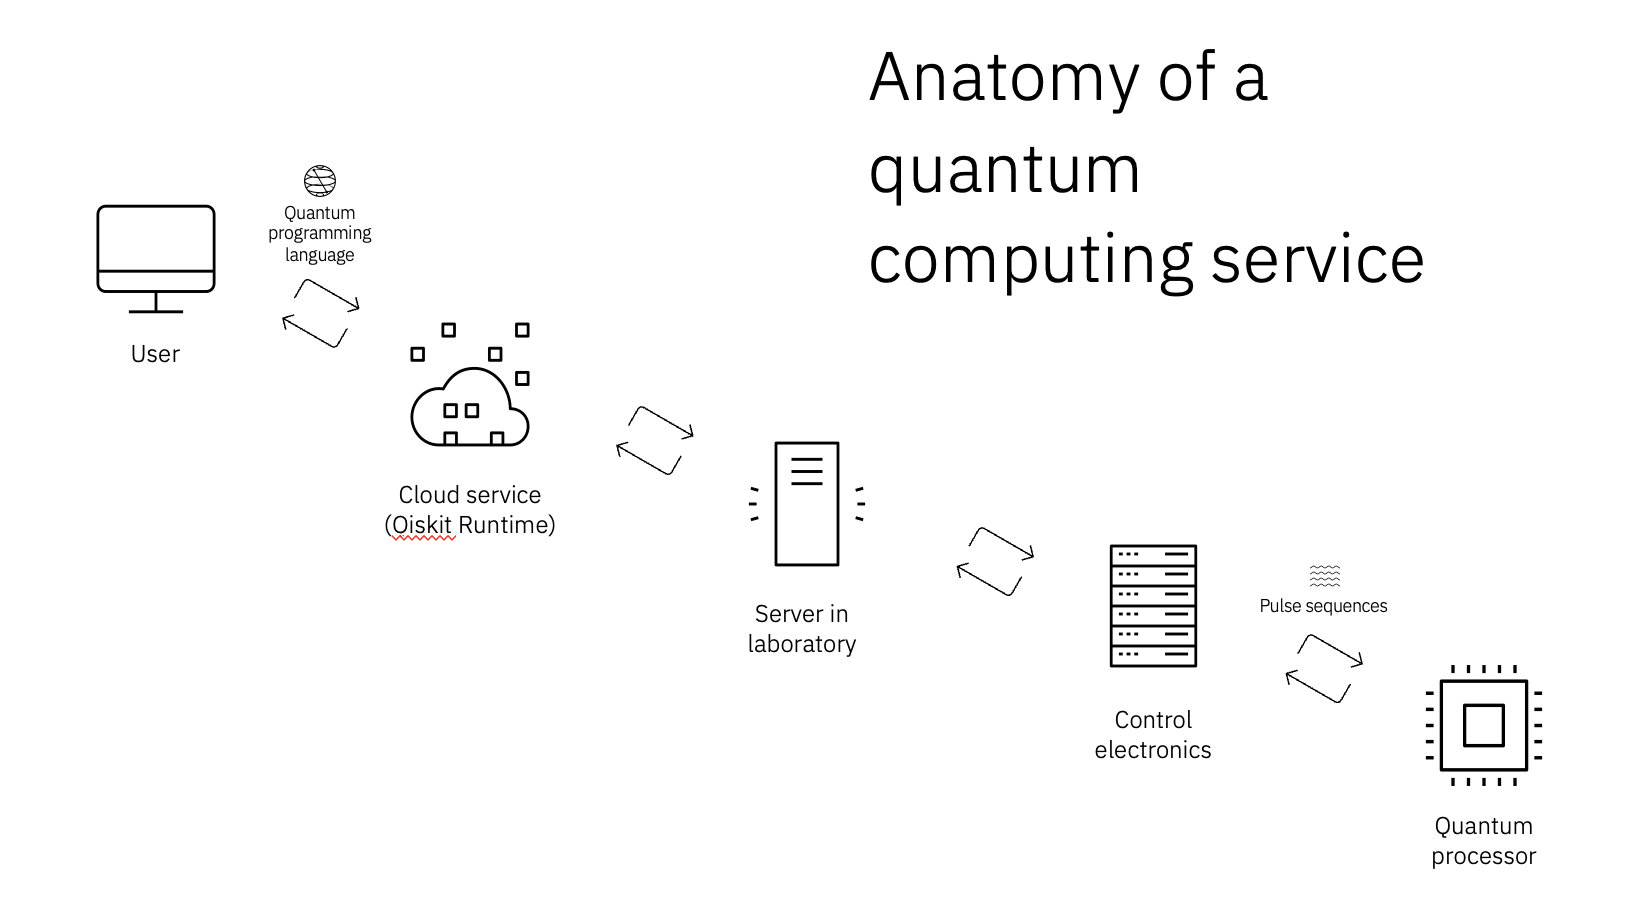

## Part 0 - Set up your IBM Quantum account and initialise the Runtime Service

Before we start developing our quantum program we need to do some initial setup to be able to access IBM quantum computers through Qiskit Runtime.

1. go to https://quantum.ibm.com and create an account
2. go to https://quantum.ibm.com/account and copy your API token
3. paste your token into the code cell below and execute the cell to save your account details


In [80]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
# Save an IBM Quantum account and set it as your default account.
QiskitRuntimeService.save_account(
    channel="ibm_quantum",
    token="<PASTE_YOUR_TOKEN_HERE>",
    set_as_default=True,
    overwrite=True
)
 
# Load saved credentials
service = QiskitRuntimeService()

## Part 1 - a small example

To get ourselves familiar with building an executing a quantum program we will start with a small example of a quantum program and then scale it up to a much larger example.

### Step 1 - map the problem to quantum circutis and operators

The first step in any quantum program is to create a quantum circuit based on whatever classical problem you are trying to solve. For this small example our objective is to create a small entangled quantum state (i.e. a Bell State).

We begin by creating a `QuantumCircuit` comprised of two qubits.

In [102]:
from qiskit import QuantumCircuit

# Create a Quantum Circuit acting on a quantum register of two qubits
circ = QuantumCircuit(2)
print(circ)

     
q_0: 
     
q_1: 
     


We can then add gates to the circuit. We start with a Hadamard gate acting on qubit $0$ and then add a $C_X$ (CNOT) gate using $0$ as the control qubit and $1$ as the target. 

In [103]:
# Add a H gate on qubit 0, putting this qubit in superposition.
circ.h(0)
# Add a CX (CNOT) gate on control qubit 0 and target qubit 1, putting
# the qubits in a Bell state.
circ.cx(0, 1)

You can visualize your circuit using the `QuantumCircuit.draw()` method, which plots the circuit in the form found in many textbooks.

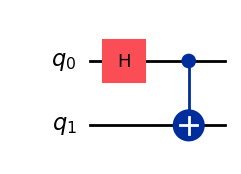

In [104]:
circ.draw('mpl')

A few of the basic gates which can be added to a quantum circuit are the:

* Pauli $X$, $Y$, $Z$ gates - `.x()` `.y()`
* Hadamard $H$ gate 
* $S$ (or $\pi/2$) phase gate
* $T$ (or $\pi/4$) phase gate
* Controlled-NOT (or Controlled-$X$) gate - `.cx`
* Controlled-$H$ gate - `.ch`
* CCX or Toffoli gate - `.ccx`

among many others.  See the Qiskit Circuit Library [documentation](https://docs.quantum.ibm.com/api/qiskit/circuit_library) for the full list of supported gates.

We also need observables TODO UPDATE EXPLANATION

In [105]:
# Import the SparesPauliOp class and create our observables variable
from qiskit.quantum_info import SparsePauliOp
 
observable = SparsePauliOp(["II", "XX", "YY", "ZZ"], coeffs=[1, 1, -1, 1])

### Step 2 - Optimize the circuit for target hardware

Next, we must optimize our circuit before running it on hardware. This process involves a few steps:

* Pick a qubit layout that maps the virtual qubits of your circuit to physical qubits on the hardware.
* Insert swap gates as needed to route interactions between qubits that are not connected.
* Translate the gates in your circuit to [Instruction Set Architecture (ISA)](https://docs.quantum.ibm.com/transpile#instruction-set-architecture) instructions that can directly be executed on the hardware.
* Perform circuit optimizations to minimize the circuit depth and gate count.

The transpiler built into Qiskit can perform all of these steps for us 🎉

The first step is selecting a quantum device that we want to transpile our circuit for. For this small example we are going to use Runtime Local Testing Mode. This will allow us to select a fake device that mimics the noise in the real device it is modelled on.

In [106]:
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

fake_manila = FakeManilaV2()

You can transpile your circuit for your chosen backend by creating a pass manager and then running the pass manager on the circuit. An easy way to create a pass manager is to use the [`generate_preset_pass_manager`](https://docs.quantum.ibm.com/api/qiskit/transpiler_preset#qiskit.transpiler.preset_passmanagers.generate_preset_pass_manager) function. See [Transpile with pass managers](https://docs.quantum.ibm.com/transpile/transpile-with-pass-managers) for a more detailed explanation of transpiling with pass managers.


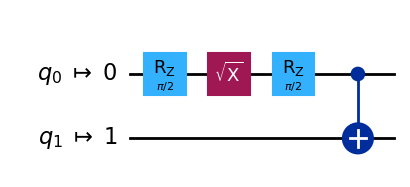

In [107]:
pm = generate_preset_pass_manager(backend=fake_manila, optimization_level=1)
isa_fake = pm.run(circ)
isa_fake.draw("mpl", idle_wires=False)

The transpiled circuit now contains only ISA instructions. The single-qubit gates have been decomposed in terms of $\sqrt{X}$ gates and $R_z$ rotations.

The transpilation process has mapped the virtual qubits of the circuit to physical qubits on the hardware. The information about the qubit layout is stored in the `layout` attribute of the transpiled circuit. The observable was also defined in terms of the virtual qubits, so you need to apply this layout to the observable, which you can do with the [`apply_layout`](https://docs.quantum.ibm.com/api/qiskit/qiskit.quantum_info.SparsePauliOp#apply_layout) method of `SparsePauliOp`.

In [108]:
isa_observable = observable.apply_layout(isa_fake.layout)

print("Original observable:")
print(observable)
print()
print("Observable with layout applied:")
print(isa_observable)

Original observable:
SparsePauliOp(['II', 'XX', 'YY', 'ZZ'],
              coeffs=[ 1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j])

Observable with layout applied:
SparsePauliOp(['IIIII', 'IIIXX', 'IIIYY', 'IIIZZ'],
              coeffs=[ 1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j])


### Step 3 - Execute on target hardware

There are two main approaches within Qiskit to execute and measure your quantum circuits called `Primitives`.  The first is the `Estimator` which computes the expectation values of observables.  Users generally specify a list of circuits, observables, and a few other optional configurations, with which the program can efficiently evaluate expectation values and variances.  The second is the `Sampler` primitive which with calculate the probabilities (or quasi-probabilities if using error mitigation) of bitstrings from quantum circuits.

Primitives work most effectively when they are supported by both Qiskit and the backend provider. The Qiskit module `qiskit.primitives` provides the foundational definition of a primitive, and providers like IBM Qiskit Runtime enable access to appropriate backends through native implementations of their own primitives.

For this lab we will be using the `Estimator` primitive.

For this small example we will use the estimator to run our circuit on the fake manila backend we initialised earlier using Runtime Local Testing Mode. This will run our circuit locally on our own classical computer, but will produce results affected by noise as if we had run it on the real Manila device. This demonstrates how local testing mode can be a useful tool for testing out how a specific device's noise could affect your program before you scale it up to a larger version and run it on the real device.

In [88]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator
 
# You can use a fixed seed to get fixed results.
options = {"simulator": {"seed_simulator": 42}}
estimator = Estimator(fake_manila, options=options)
 
result = estimator.run([(isa_fake, isa_observable)]).result()

print(result)
print(f"Expectation value: {result[0].data.evs}")
print(f"Metadata: {result[0].metadata}")

PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(), dtype=float64>), stds=0.02050346231870258), metadata={'target_precision': 0.015625})], metadata={})
Expectation value: 2.95751953125
Metadata: {'target_precision': 0.015625}


Because we are starting off with a very small example we can use our local classical computer to calculate what the exact answer would be for this program, i.e. what the result would be without any noise at all. We can do this using the Qiskit SDK reference primitives. Because we are not trying to use a quantum computer (real or fake) for this step we do not need to transpile the circuit or observables.

In [89]:
from qiskit.primitives import Estimator

estimator = Estimator()

job = estimator.run(circ, observable)
result_exact = job.result()
print(result_exact)
print(f"Expectation value: {result_exact.values[0]:.3f}")
print(f"Metadata: {result_exact.metadata}")

EstimatorResult(values=array([4.]), metadata=[{}])
Expectation value: 4.000
Metadata: [{}]


### Step 4 - Post-process results

Now lets compare the ideal result with the "noisy" one by plotting them on a simple histogram:

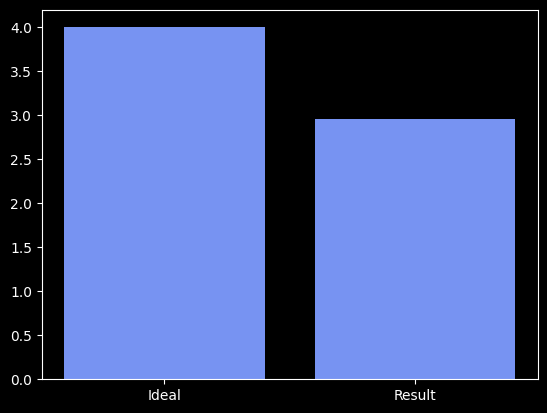

In [90]:
from qiskit.visualization import plot_histogram

import matplotlib.pyplot as plt
plt.style.use('dark_background')

data = {"Ideal": result_exact.values[0],"Result": result[0].data.evs}
plt.bar(range(len(data)), data.values(), align='center', color = "#7793f2")
plt.xticks(range(len(data)), list(data.keys()))

plt.show()

### so how do we get the real result closer to the ideal? Error mitigation and suppression!

## Part 2 - let's scale it up!

Now that we understand how to construct a quantum program and how device noise can affect the results, we're going to scale this up to a larger example and demonstrate how error mitigation and suppression techniques can get us closer to an ideal result. We will also run this program on a real device rather than using local testing mode.

### Step 1 - map the problem to quantum circuits and operators

First we'll create quantum circuit, using the `EfficientSU2` class from Qiskit's circuit library. We chose this circuit specifically because it is a nice and simple example for demonstrating the error mitigation techniques in this lab, although the techniques we apply can be used in the same way with many different circuit types.

`EfficientSU2` is a parameterized quantum circuit designed to be efficiently executable on quantum hardware with limited qubit connectivity, while still being expressive enough to solve problems in application domains like optimization and chemistry. It's built by alternating layers of parameterized single-qubit gates with a layer containing a fixed pattern of two-qubit gates, for a chosen number of repetitions. The pattern of two-qubit gates can be specified by the user. Here you can use the built-in pairwise pattern because it minimizes the circuit depth by packing the two-qubit gates as densely as possible. This pattern can be executed using only linear qubit connectivity.

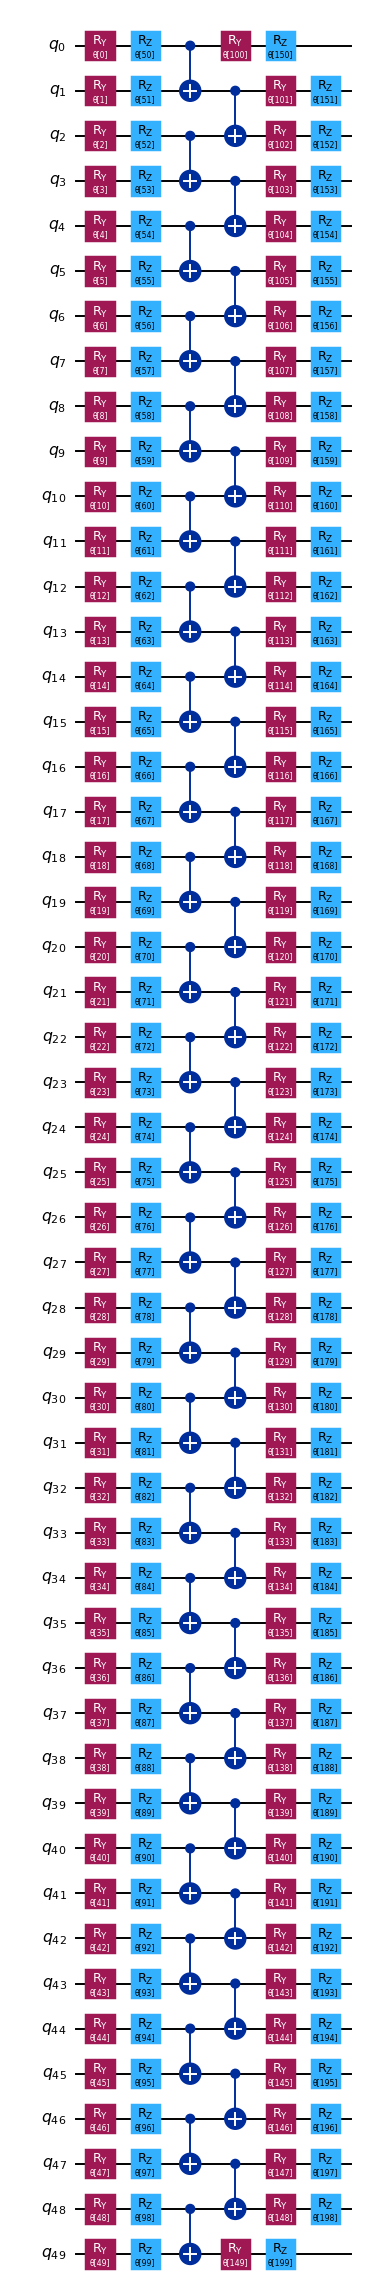

In [91]:
from qiskit.circuit.library import EfficientSU2

n_qubits = 50
reps = 1

circuit = EfficientSU2(n_qubits, entanglement="pairwise", reps=reps)

circuit.decompose().draw("mpl", scale=0.7)

For our observable, let's take the Pauli $Z$ operator acting on the last qubit, $Z I \cdots I$.

In [96]:
from qiskit.quantum_info import SparsePauliOp

# Z on the last qubit (index -1) with coefficient 1.0
observable = SparsePauliOp.from_sparse_list([("Z", [-1], 1.0)], num_qubits=n_qubits)

At this point, we could proceed to run the circuit and measure the observable like we did for the small scale example. However, we also want to compare the output of the quantum device with the correct answer - that is, the theoretical value of the observable, if the circuit had been executed without error. For the small circuit we executed earlier we could calculate this value by simulating the circuit on a classical computer, but this is not possible for larger, utility-scale circuits like this one. We can work around this issue with the "mirror circuit" technique (also known as "compute-uncompute"), which is useful for benchmarking the performance of quantum devices.

In the mirror circuit technique, you concatenate the circuit with its inverse circuit, which is formed by inverting each gate of the circuit in reverse order. The resulting circuit implements the identity operator, which can trivially be simulated. Because the structure of the original circuit is preserved in the mirror circuit, executing the mirror circuit still gives an idea of how the quantum device would perform on the original circuit.

The following code cell assigns random parameters to your circuit, and then constructs the mirror circuit using the UnitaryOverlap class. Before mirroring the circuit, append a barrier instruction to it to prevent the transpiler from merging the two parts of the circuit on either side of the barrier. Without the barrier, the transpiler would merge the original circuit with its inverse, resulting in a transpiled circuit without any gate.

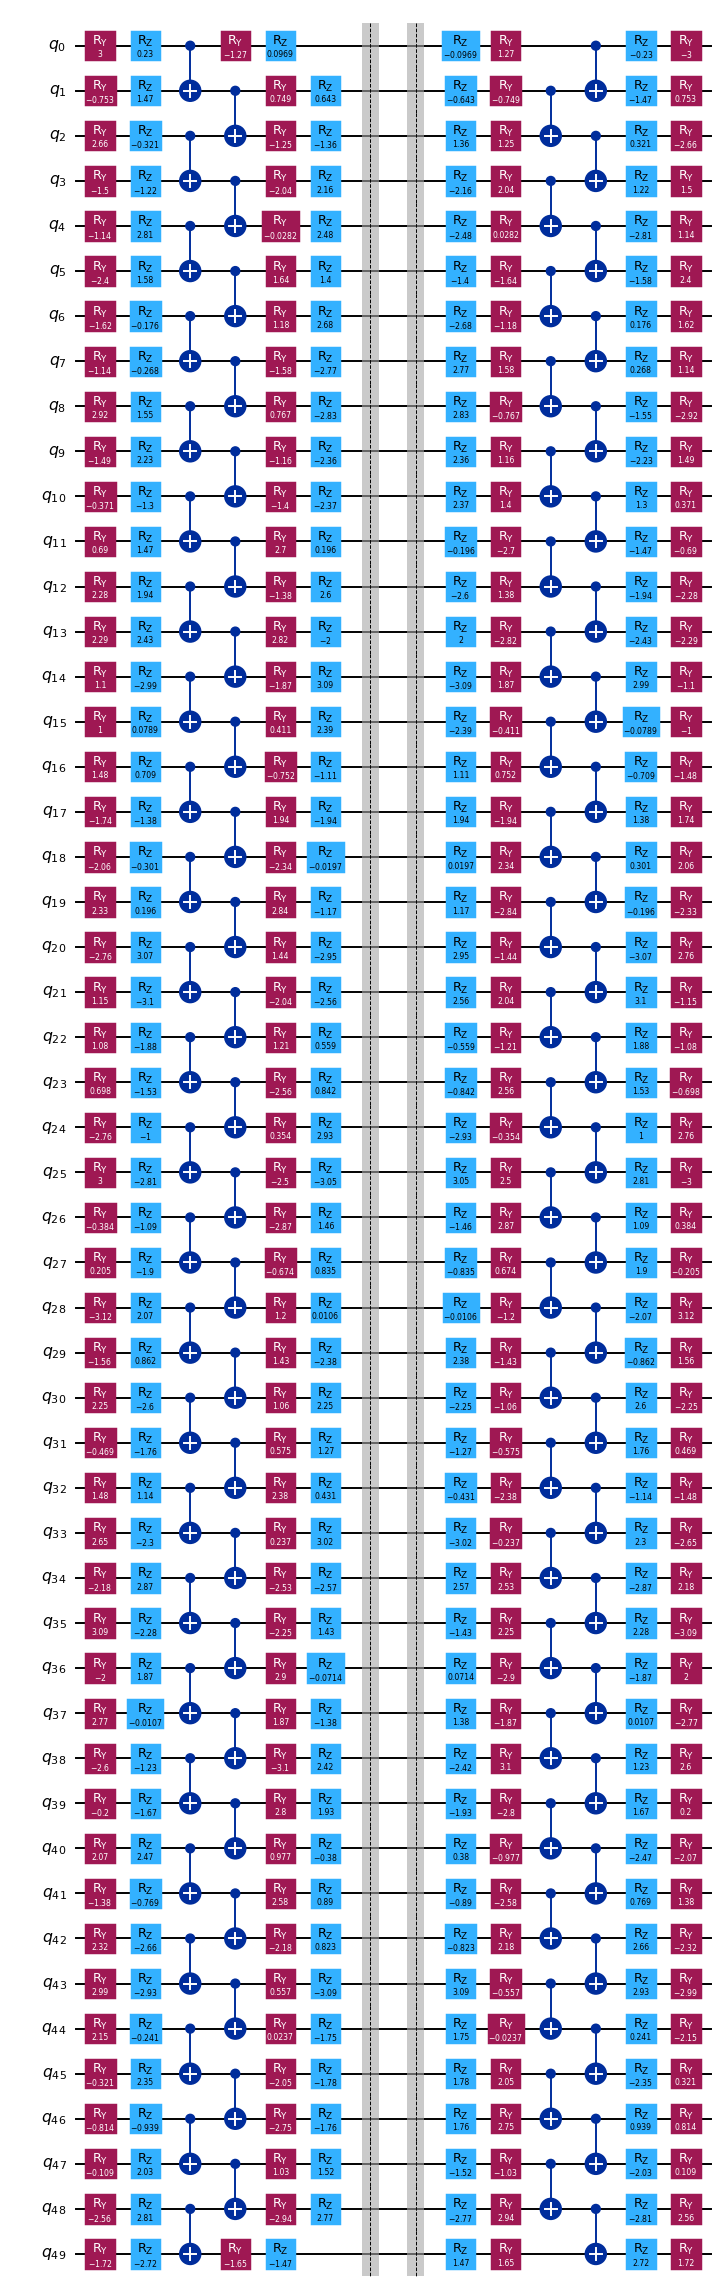

In [97]:
import numpy as np
from qiskit.circuit.library import UnitaryOverlap

# Generate random parameters
rng = np.random.default_rng(1234)
params = rng.uniform(-np.pi, np.pi, size=circuit.num_parameters)

# Assign the parameters to the circuit
assigned_circuit = circuit.assign_parameters(params)

# Add a barrier to prevent circuit optimization of mirrored operators
assigned_circuit.barrier()

# Construct mirror circuit
mirror_circuit = UnitaryOverlap(assigned_circuit, assigned_circuit)

mirror_circuit.decompose().draw("mpl", scale=0.7)

### Step 2 - Optimize for target hardware

We can follow the same process for transpiling our circuit as we did in the small example, but this time instead of transpiling for a fake backend we will choose a real quantum computer.

Because there are a limited number of quantum devices available you will normally need to wait in a queue for some time before you can run your program. To reduce queue times it is helpful to select the "least busy" device to run your program. As we are running a utility scale circuit we also need to specify that we want to use a device with a minimum of 127 qubits.

In [93]:
backend = service.least_busy(min_num_qubits=127)

print(backend)

<IBMBackend('ibm_torino')>


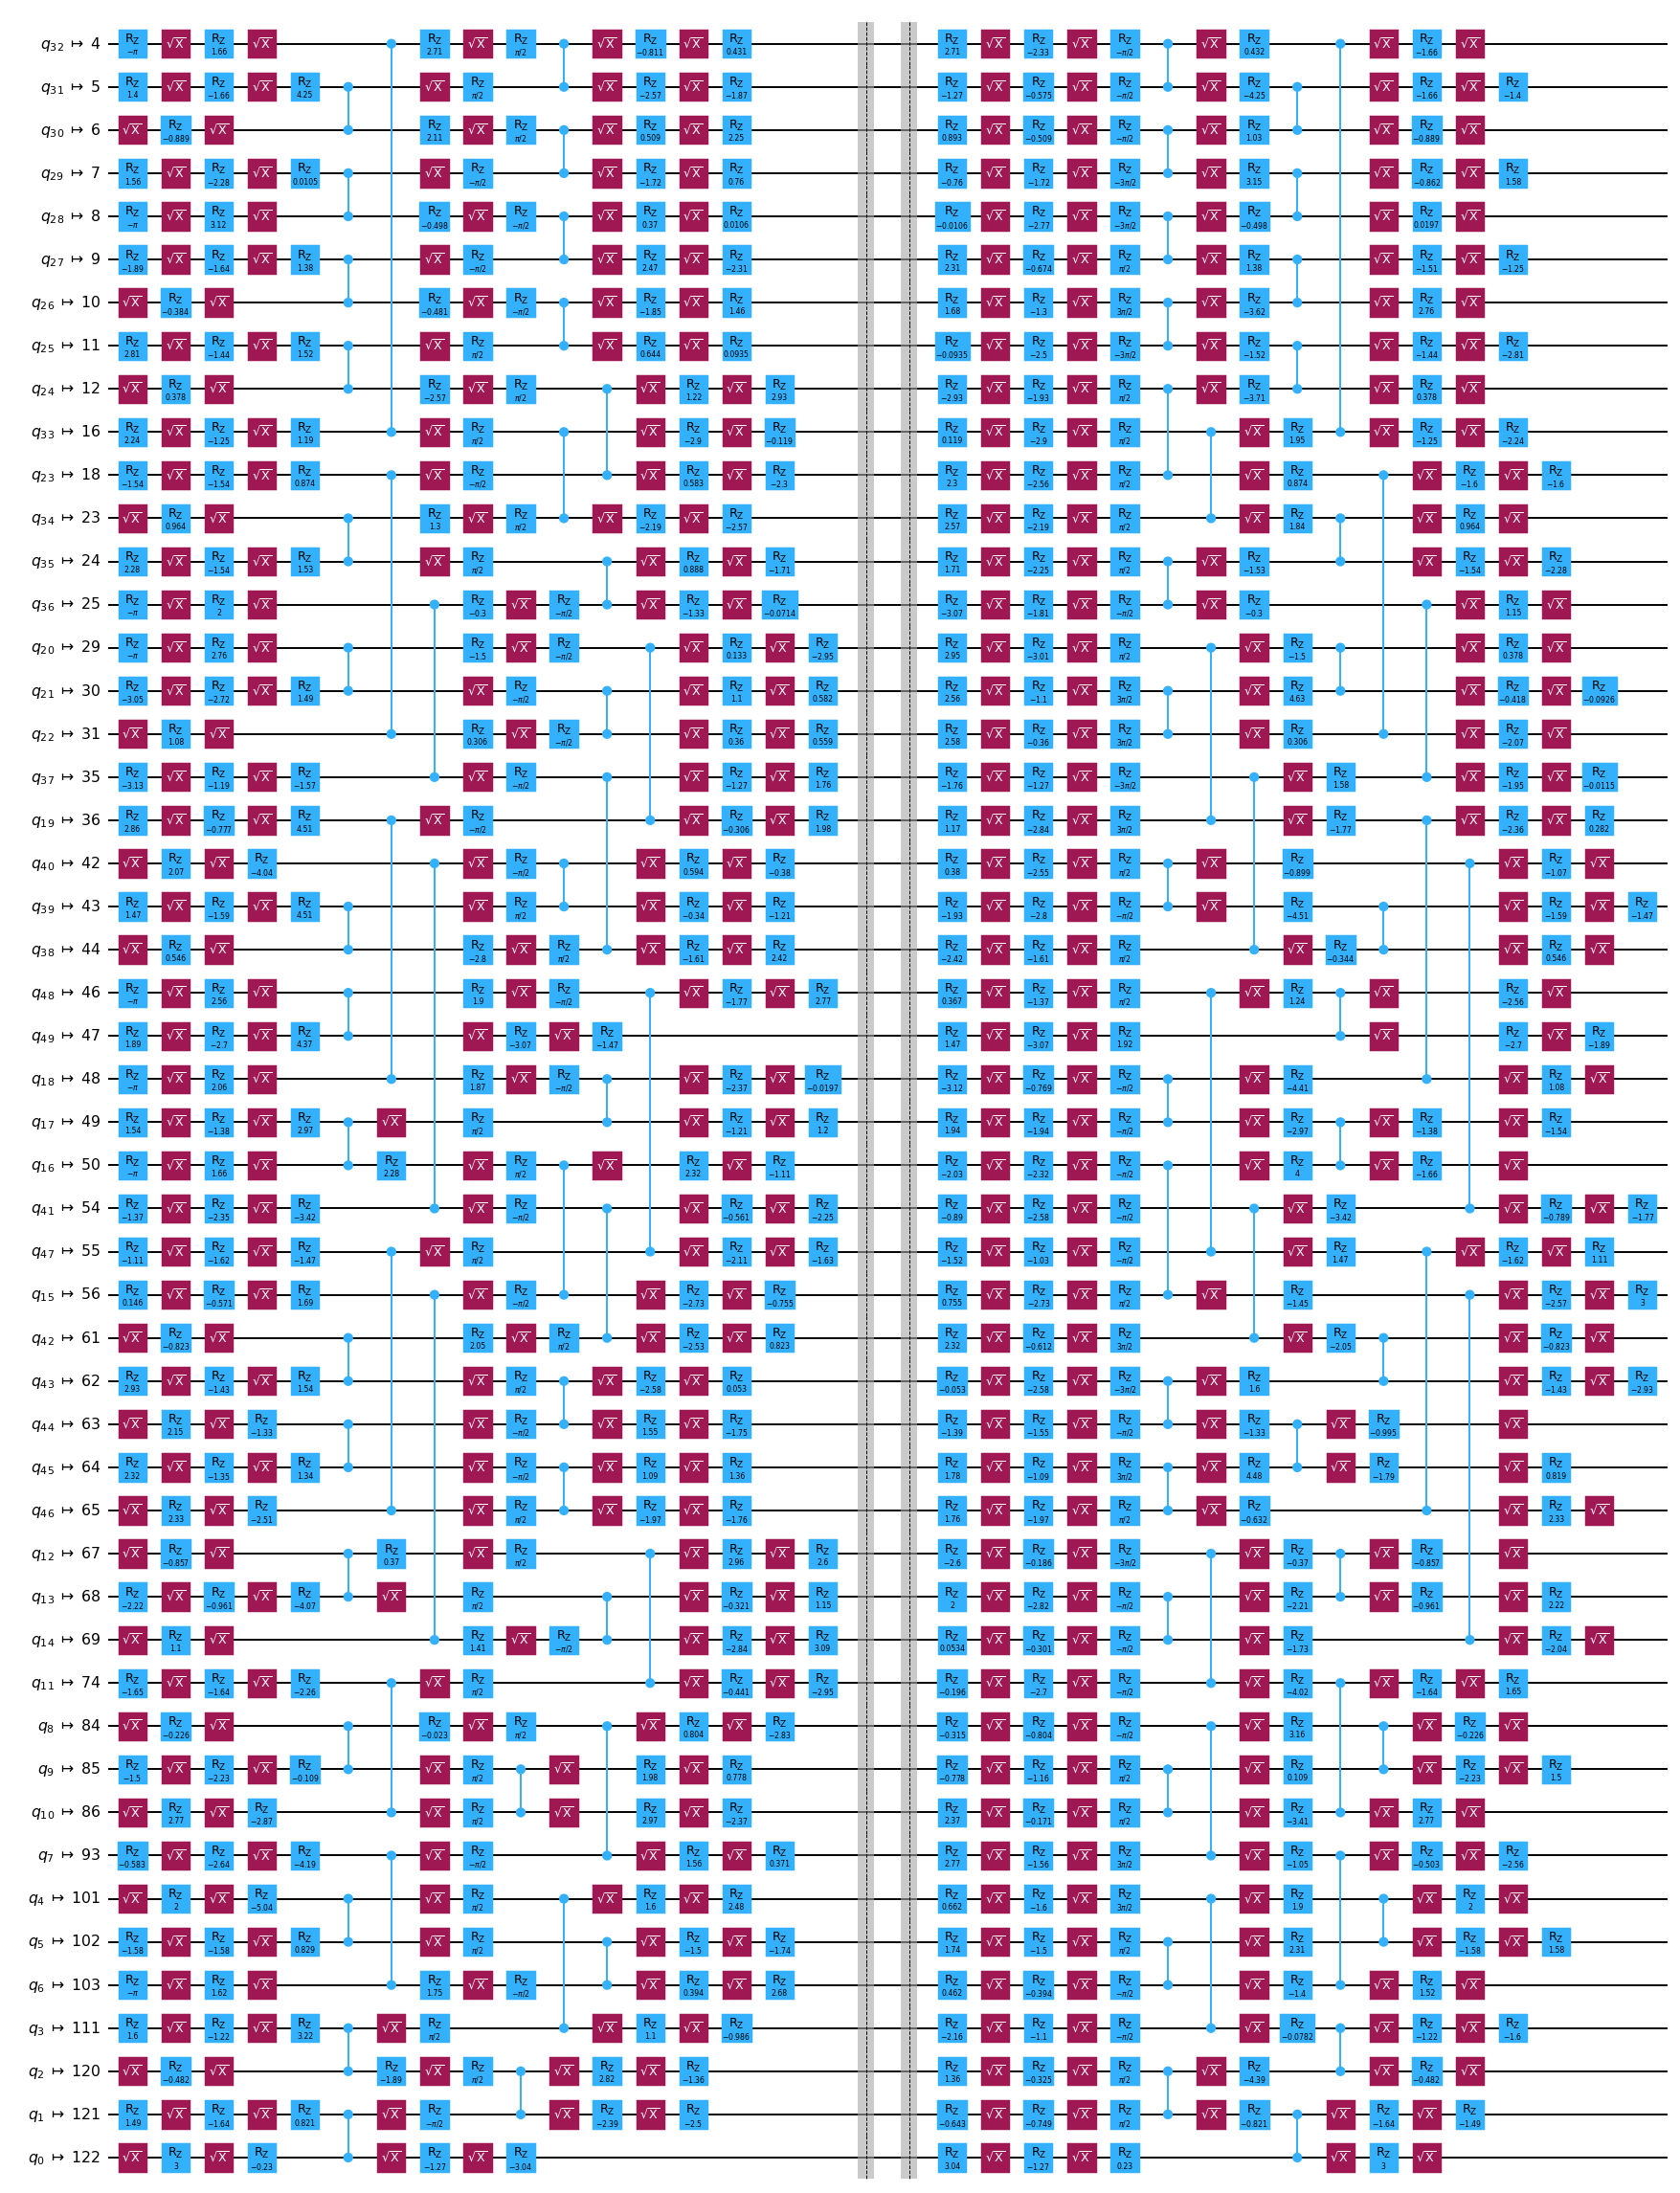

In [98]:
pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend, seed_transpiler=1234
)
isa_circuit = pass_manager.run(mirror_circuit)

isa_circuit.draw("mpl", idle_wires=False, scale=0.7, fold=-1)

The transpiled circuit now contains only ISA instructions. The single-qubit gates have been decomposed in terms of $\sqrt{X}$ gates and $R_z$ rotations, and the CX gates have been decomposed into [ECR gates](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.ECRGate#ecrgate) and single-qubit rotations.

The transpilation process has mapped the virtual qubits of the circuit to physical qubits on the hardware. The information about the qubit layout is stored in the `layout` attribute of the transpiled circuit. The observable was also defined in terms of the virtual qubits, so you need to apply this layout to the observable, which you can do with the [`apply_layout`](https://docs.quantum.ibm.com/api/qiskit/qiskit.quantum_info.SparsePauliOp#apply_layout) method of `SparsePauliOp`.

In [99]:
isa_observable = observable.apply_layout(isa_circuit.layout)

print("Original observable:")
print(observable)
print()
print("Observable with layout applied:")
print(isa_observable)

Original observable:
SparsePauliOp(['ZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j])

Observable with layout applied:
SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j])


### Step 3 - Execute on target hardware

We are now ready to run our circuit using the Estimator primitive and compare different combinations of error mitigation techniques.

First, if you're not already familiar with quantum error mitigation and suppression techniques, read through the following summaries of the techniques we'll be using:


#### Dynamical decoupling
Quantum circuits are executed on IBM® hardware as sequences of microwave pulses that need to be scheduled and run at precise time intervals. Unfortunately, unwanted interactions between qubits can lead to coherent errors on idling qubits. Dynamical decoupling works by inserting pulse sequences on idling qubits to approximately cancel out the effect of these errors. Each inserted pulse sequence amounts to an identity operation, but the physical presence of the pulses has the effect of suppressing errors. There are many possible choices of pulse sequences, and which sequence is better for each particular case remains an active area of research(opens in a new tab).

Note that dynamical decoupling is mainly useful for circuits containing gaps in which some qubits sit idle without any operations acting on them. If the operations in the circuit are packed very densely, such that all of the qubits are busy most of the time, then the addition of dynamical decoupling pulses might not improve performance. In fact, it could even worsen performance due to imperfections in the pulses themselves.

The diagram below depicts dynamical decoupling with an XX pulse sequence. The abstract circuit on the left is mapped onto a microwave pulse schedule on the top right. The bottom right depicts the same schedule, but with a sequence of two X pulses inserted during an idle period of the first qubit.

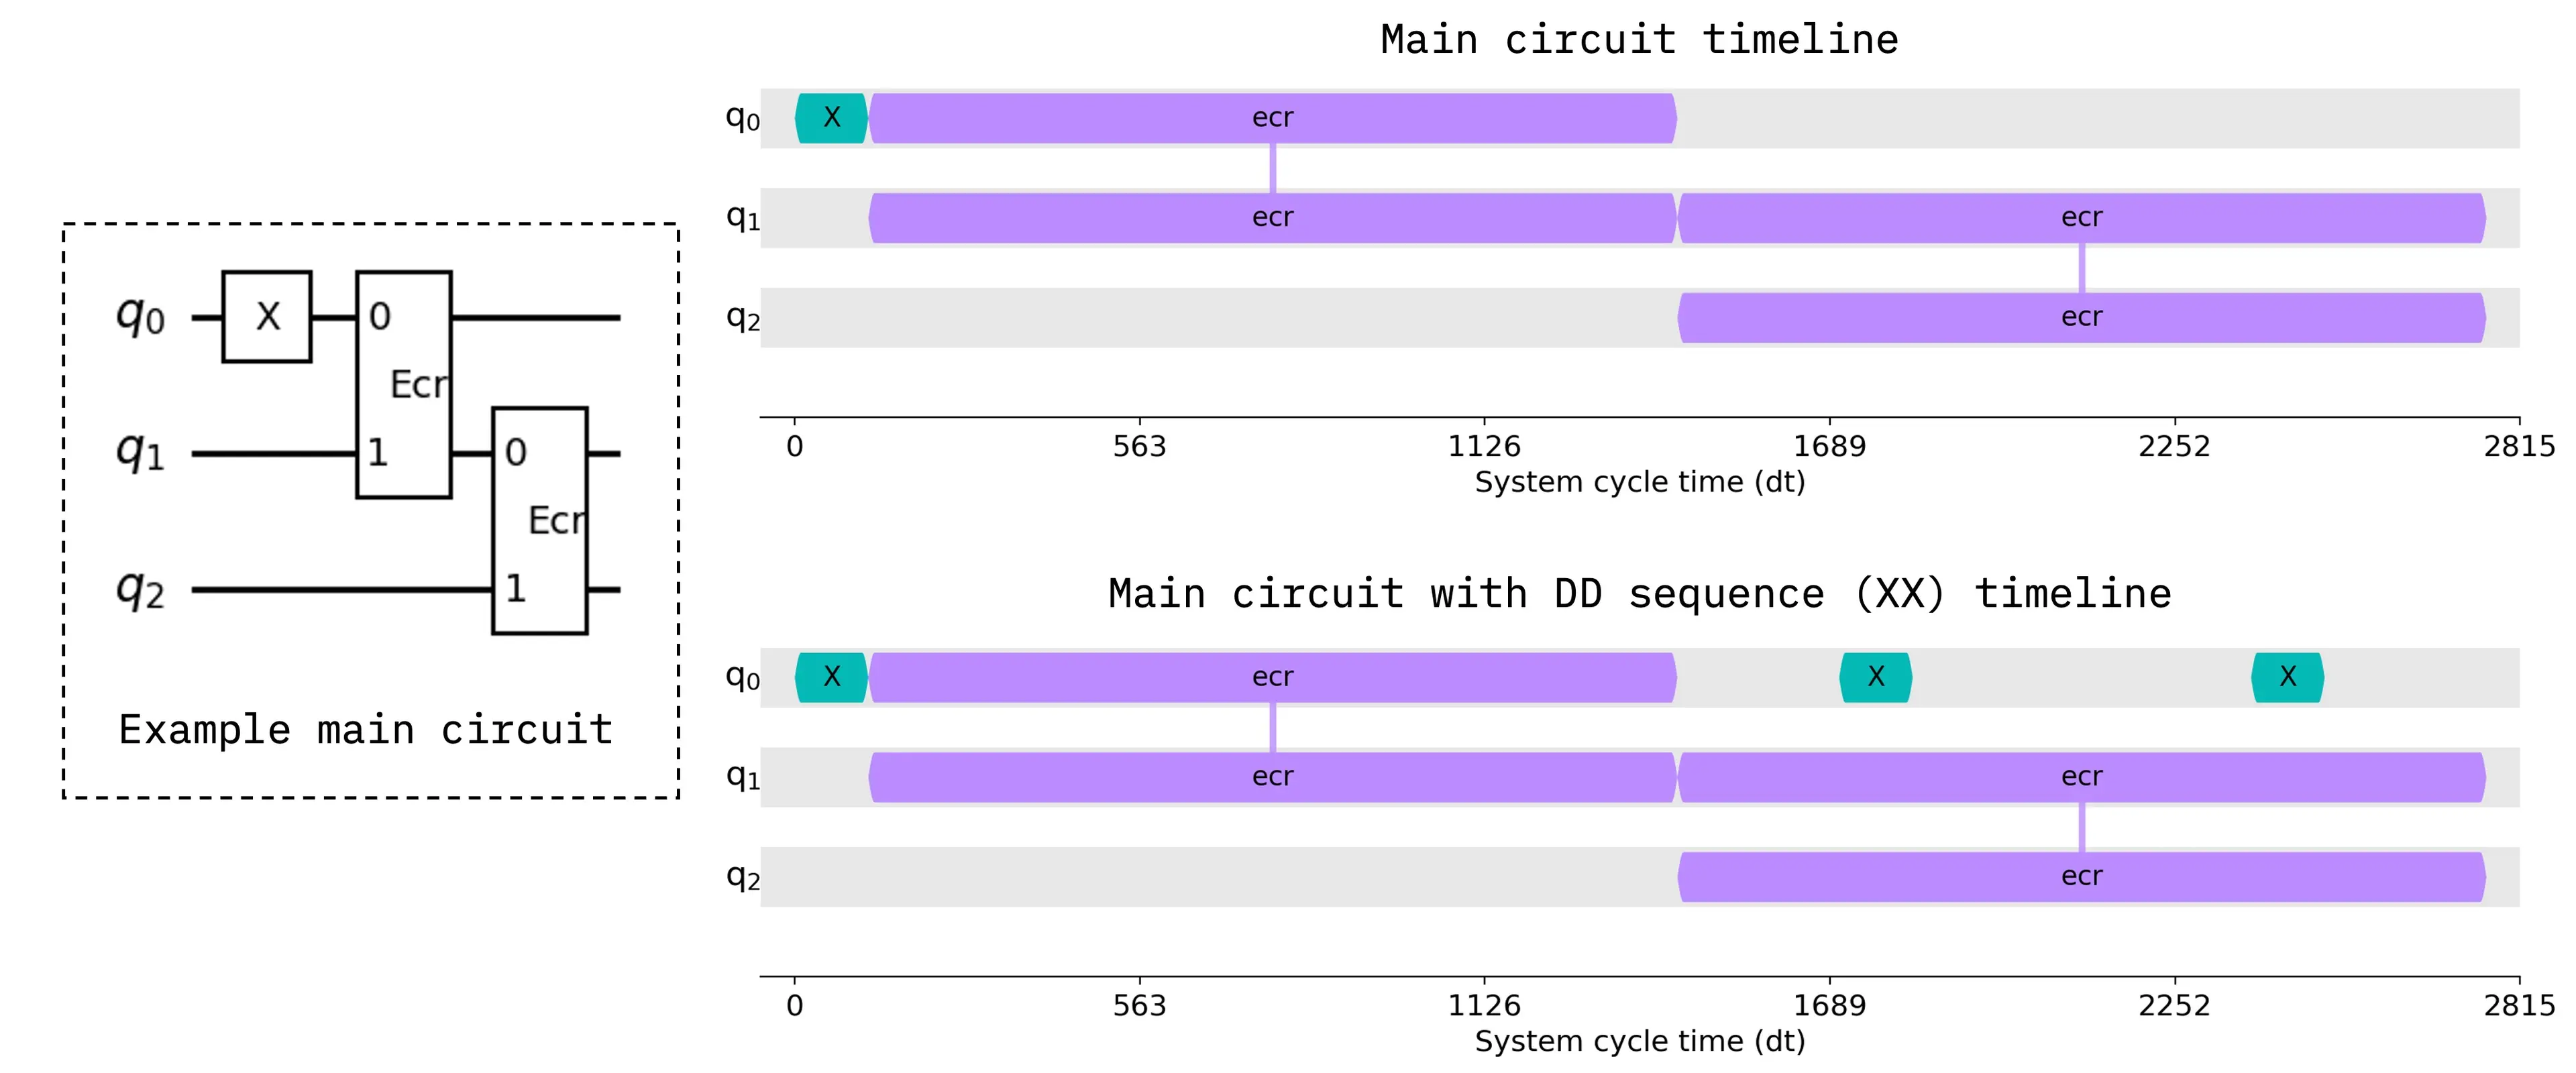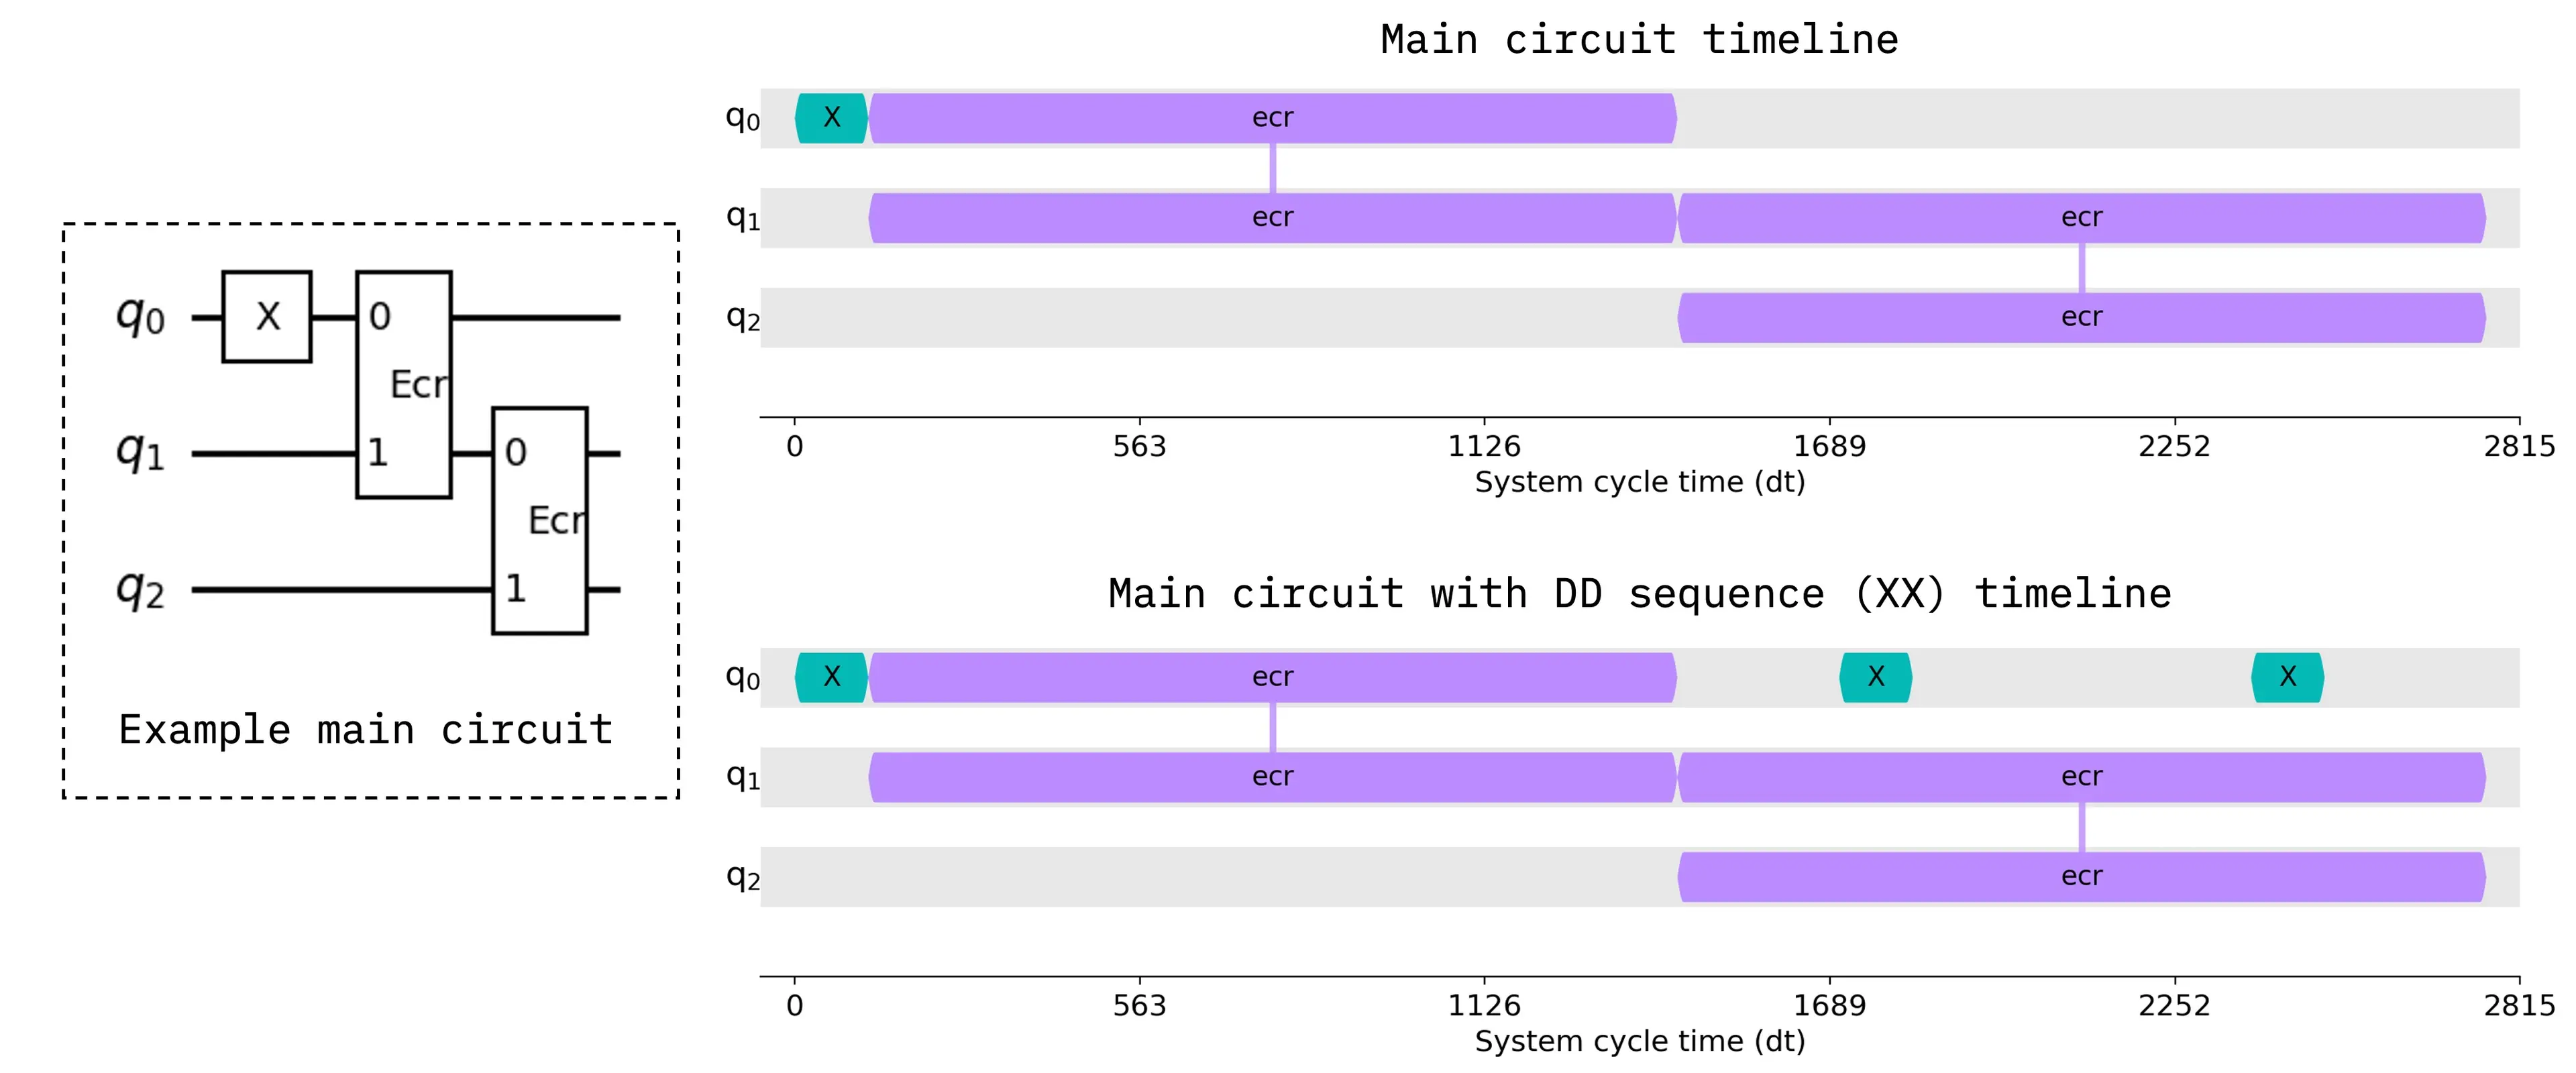

#### Pauli twirling
Twirling, also known as randomized compiling(opens in a new tab), is a widely used technique for converting arbitrary noise channels into noise channels with more specific structure.

Pauli twirling is a special kind of twirling that uses Pauli operations. It has the effect of transforming any quantum channel into a Pauli channel. Performed alone, it can mitigate coherent noise because coherent noise tends to accumulate quadratically with the number of operations, whereas Pauli noise accumulates linearly. Pauli twirling is often combined with other error mitigation techniques that work better with Pauli noise than with arbitrary noise.

Pauli twirling is implemented by sandwiching a chosen set of gates with randomly chosen single-qubit Pauli gates in such a way that the ideal effect of the gate remains the same. The result is that a single circuit is replaced with a random ensemble of circuits, all with the same ideal effect. When sampling the circuit, samples are drawn from multiple random instances, rather than just a single one.

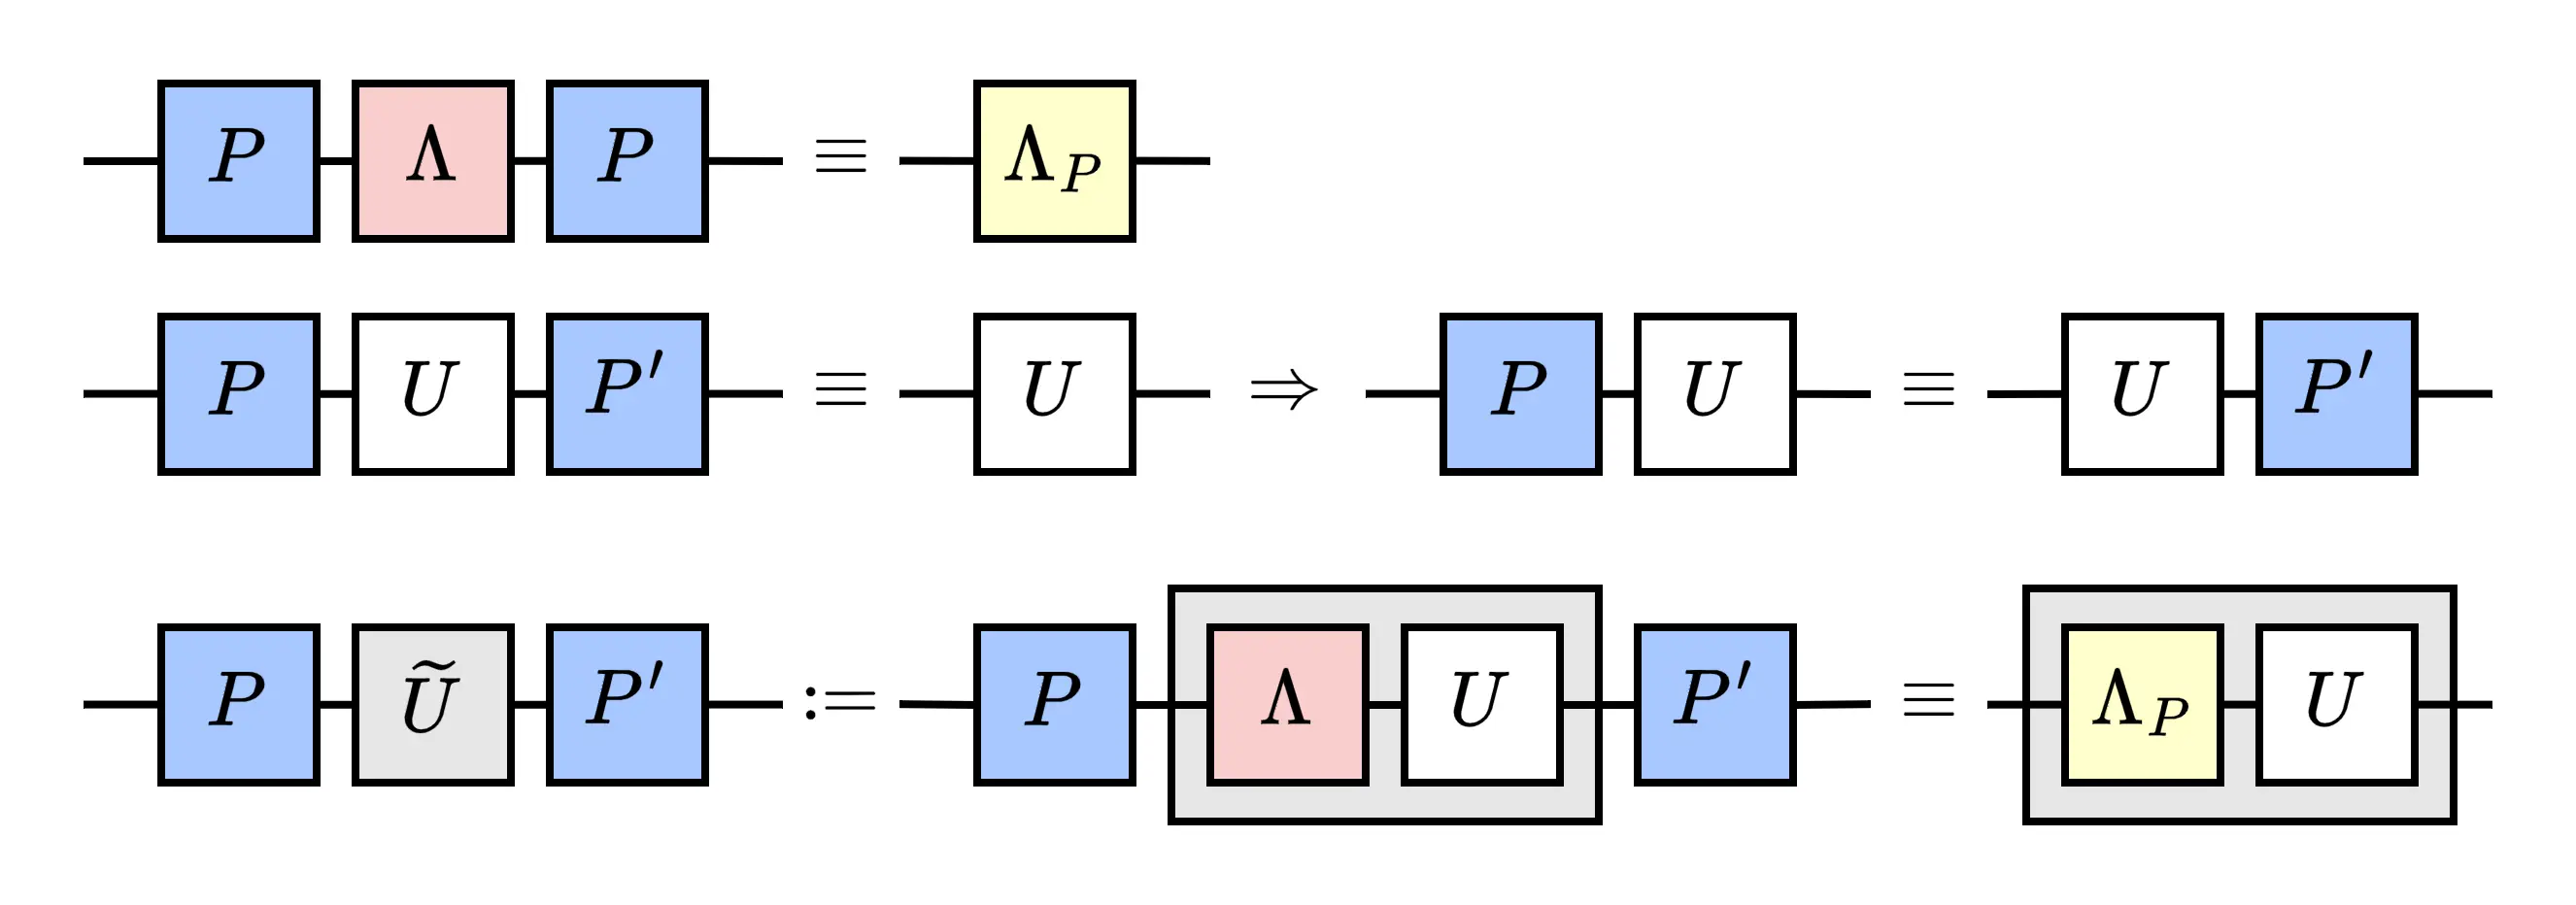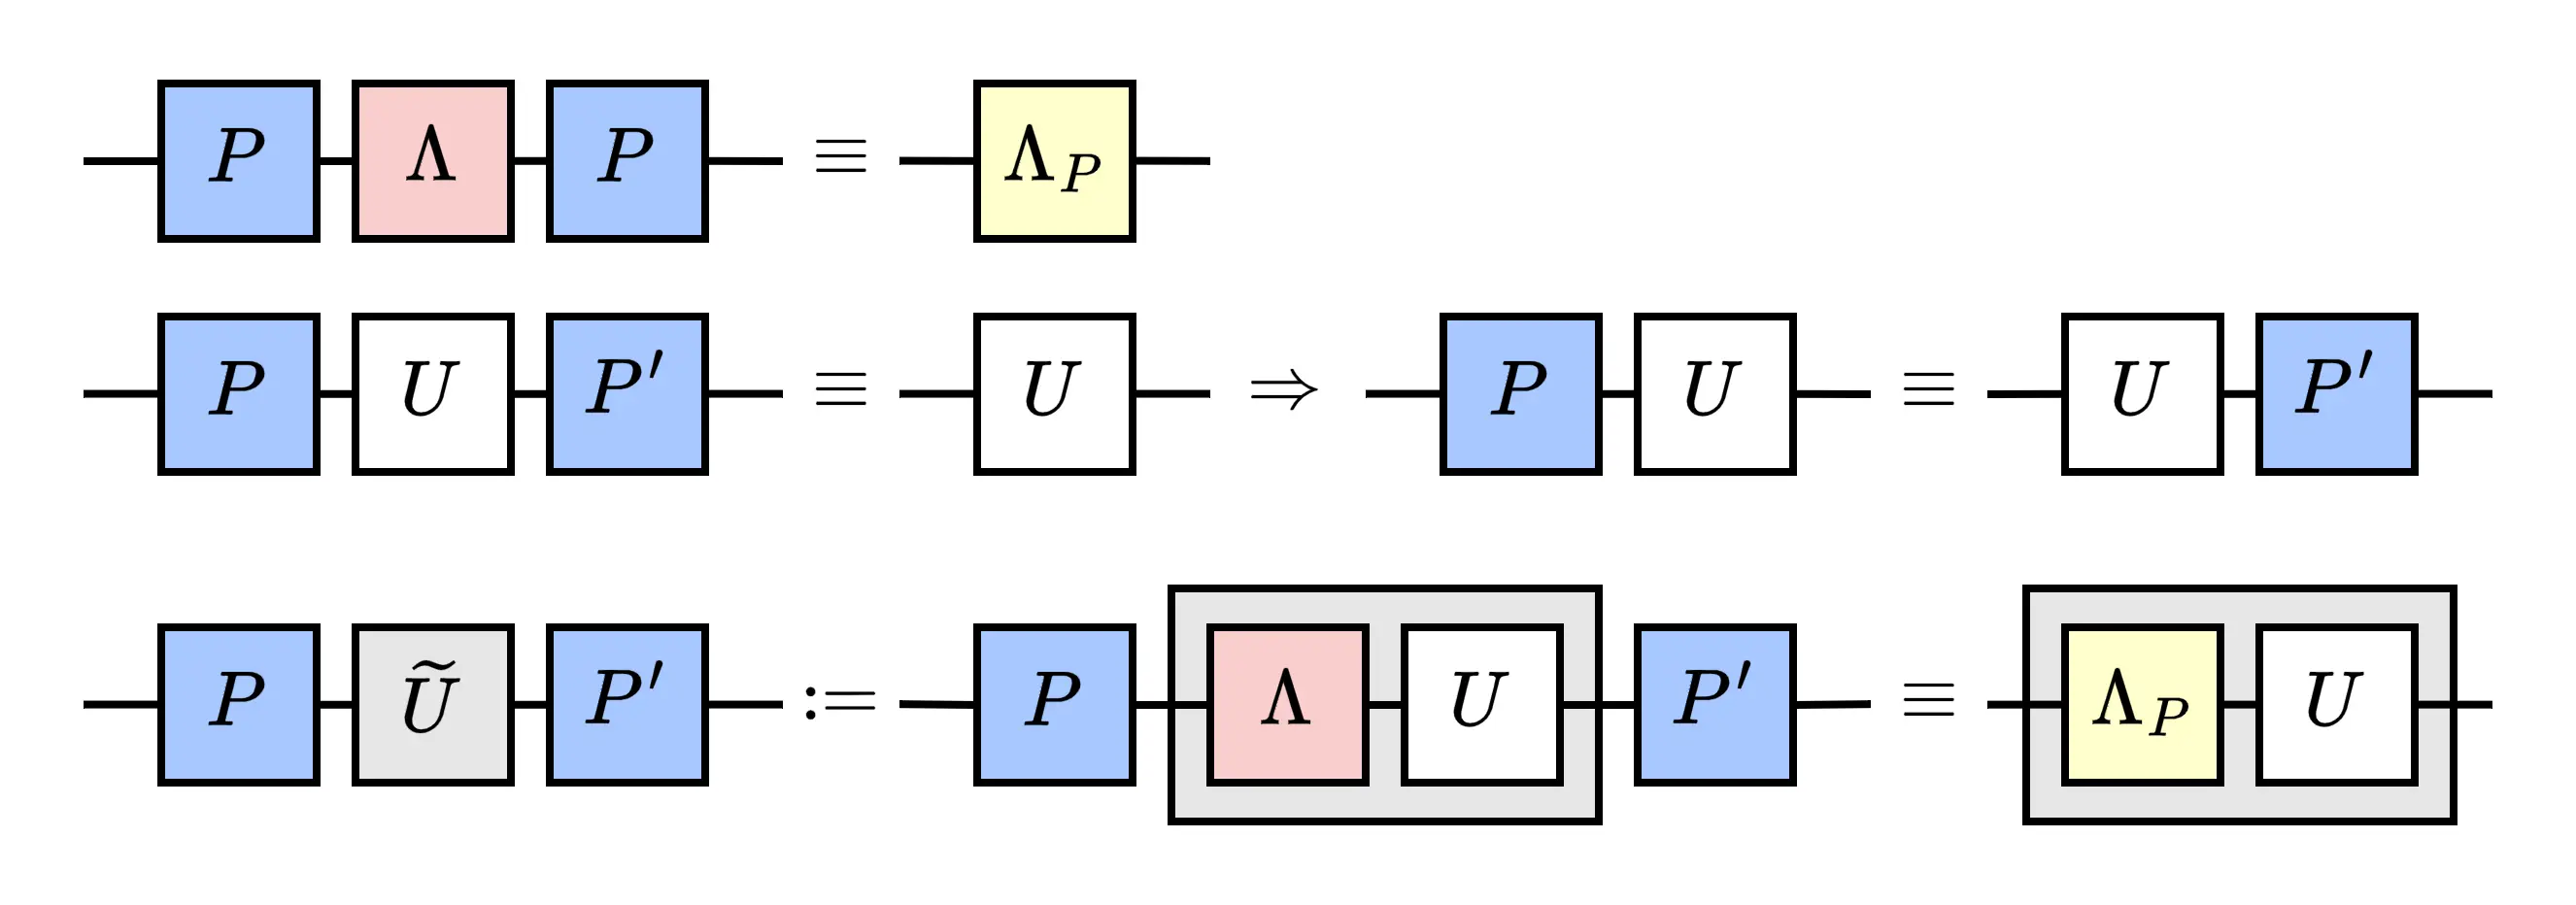

Since most of the errors in current quantum hardware come from two-qubit gates, this technique is often applied exclusively to (native) two-qubit gates. The following diagram depicts some Pauli twirls for the CNOT and ECR gates. Every circuit within a row has the same ideal effect.

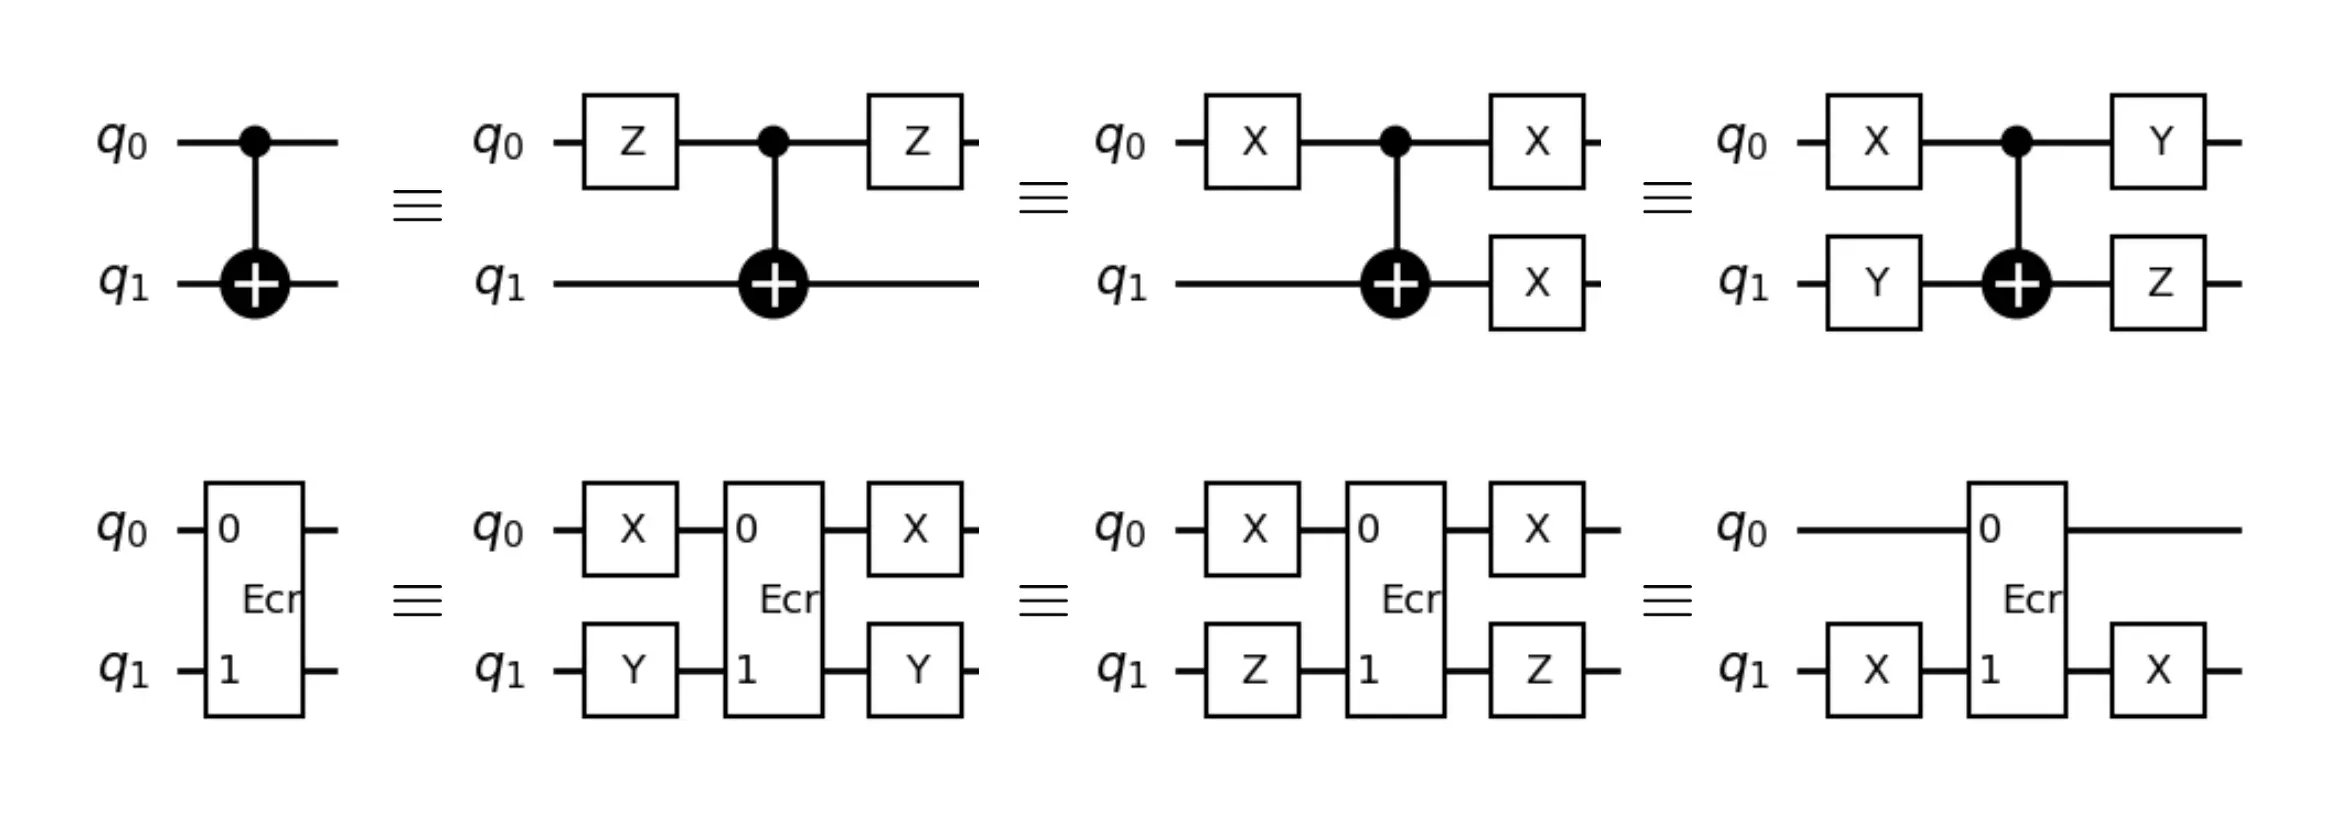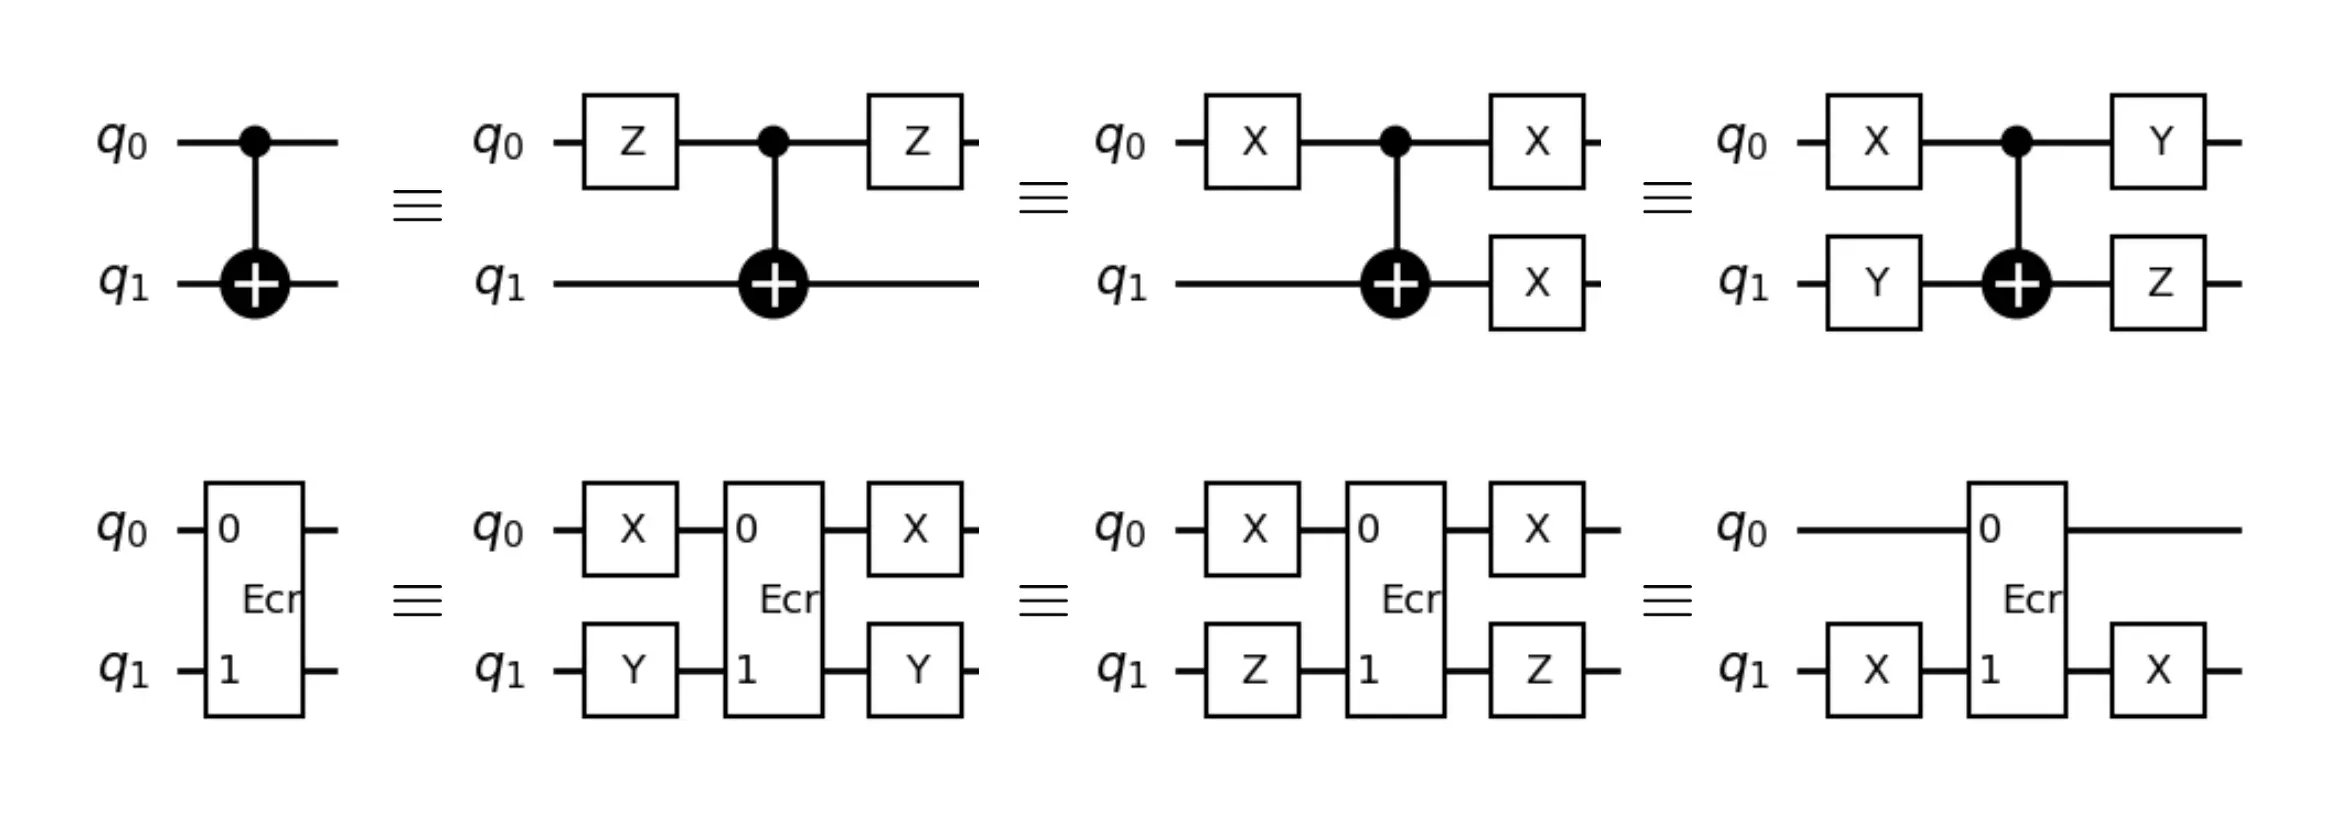


#### Twirled readout error extinction (TREX)
Twirled readout error extinction (TREX)(opens in a new tab) mitigates the effect of measurement errors for the estimation of Pauli observable expectation values. It is based on the notion of twirled measurements, which are accomplished by randomly substituting measurement gates by a sequence of (1) a Pauli X gate, (2) a measurement, and (3) classical bit flip. Just like in standard gate twirling, this sequence is equivalent to a plain measurement in the absence of noise, as depicted in the following diagram:

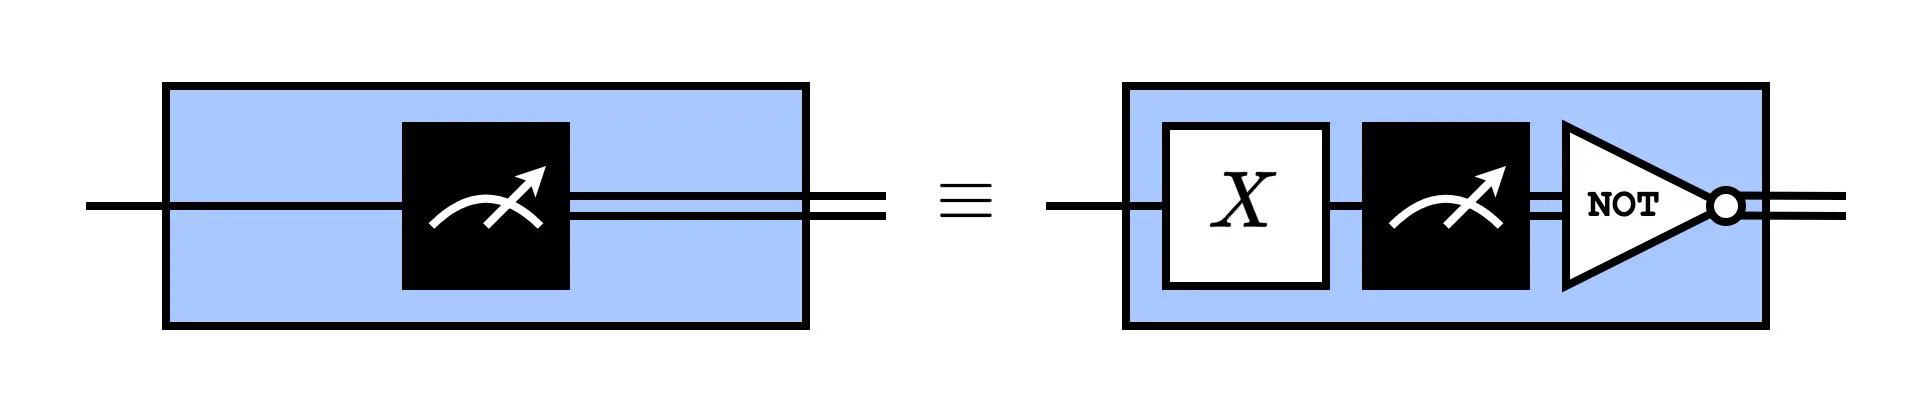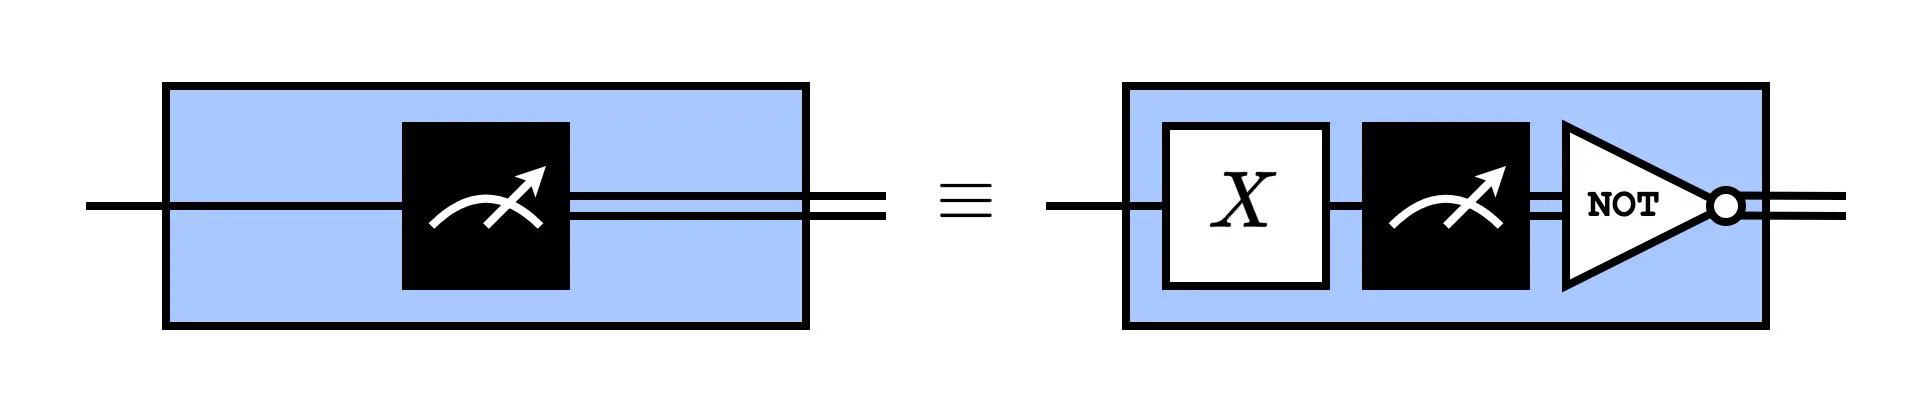

In the presence of readout error, measurement twirling has the effect of diagonalizing the readout-error transfer matrix, making it easy to invert. Estimating the readout-error transfer matrix requires executing additional calibration circuits, which introduces a small overhead.

TREX can be enabled by setting measure_mitigation to True in the Qiskit Runtime resilience options for V2 Estimator. Options for measurement noise learning are described here. As with gate twirling, you can set the number of circuit randomizations and the number of shots per randomization.

#### Zero-noise extrapolation (ZNE)
Zero-noise extrapolation (ZNE) is a technique for mitigating errors in estimating expectation values of observables. While it often improves results, it is not guaranteed to produce an unbiased result.

ZNE consists of two stages:

Noise amplification: The original quantum circuit is executed multiple times at different noise rates.
Extrapolation: The ideal result is estimated by extrapolating the noisy expectation value results to the zero-noise limit.
Both the noise amplification and extrapolation stages can be implemented in many different ways. Qiskit Runtime implements noise amplification by "digital gate folding," which means that two-qubit gates are replaced with equivalent sequences of the gate and its inverse. For example, replacing a unitary 𝑈𝑈 with 𝑈𝑈†𝑈 would yield a noise amplification factor of 3. For the extrapolation, you can choose from one of several functional forms, including a linear fit or an exponential fit. The image below depicts digital gate folding on the left, and the extrapolation procedure on the right.

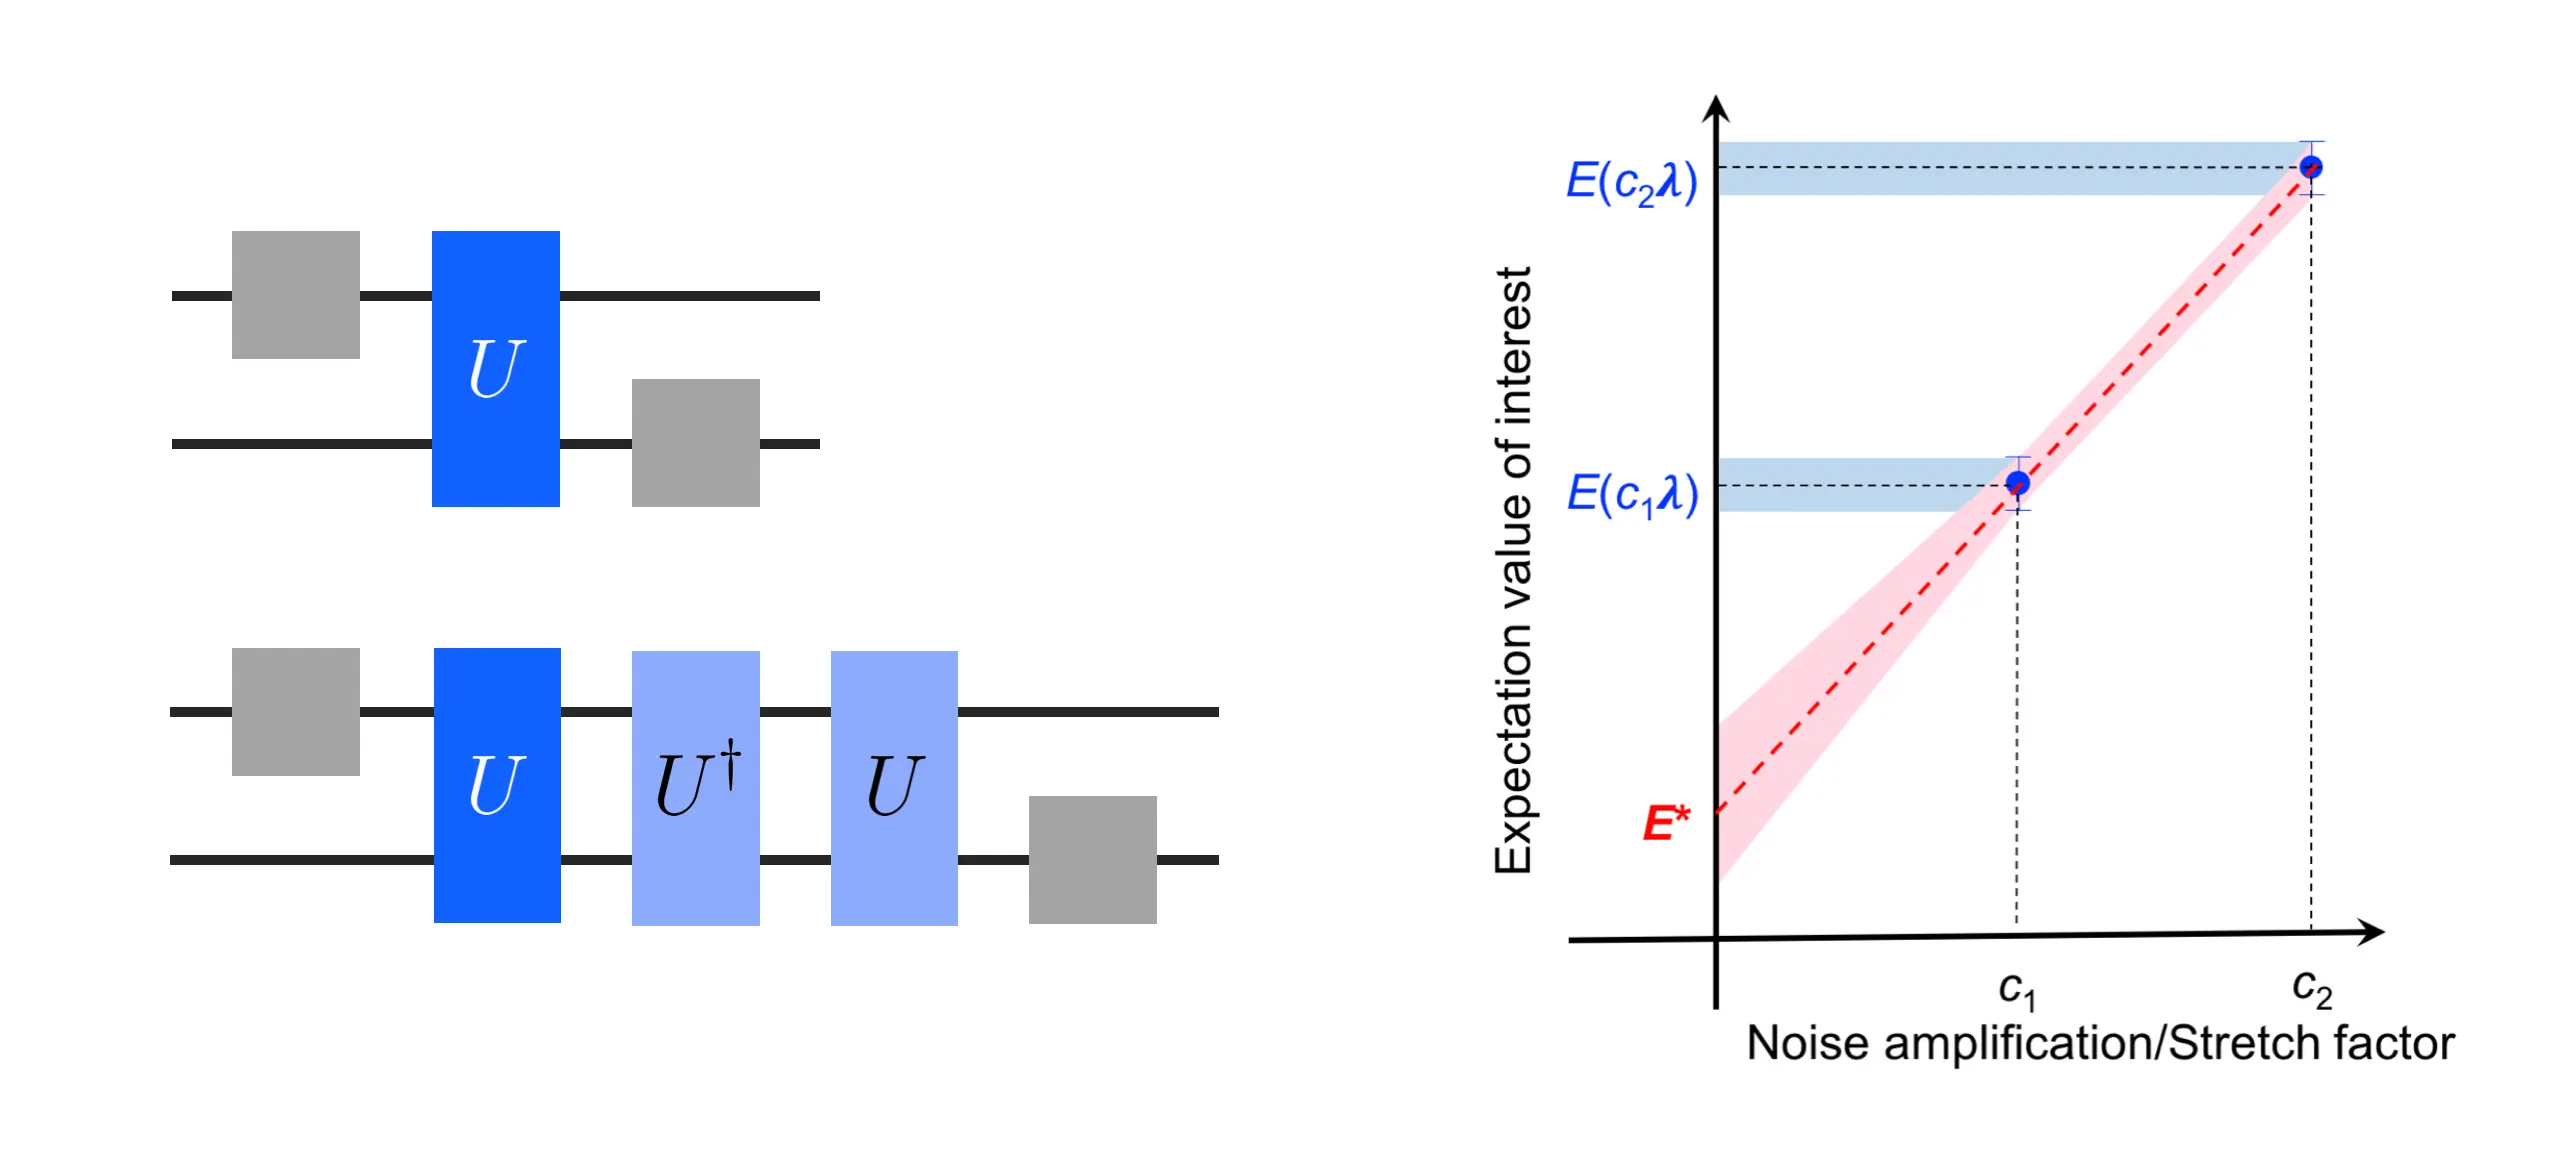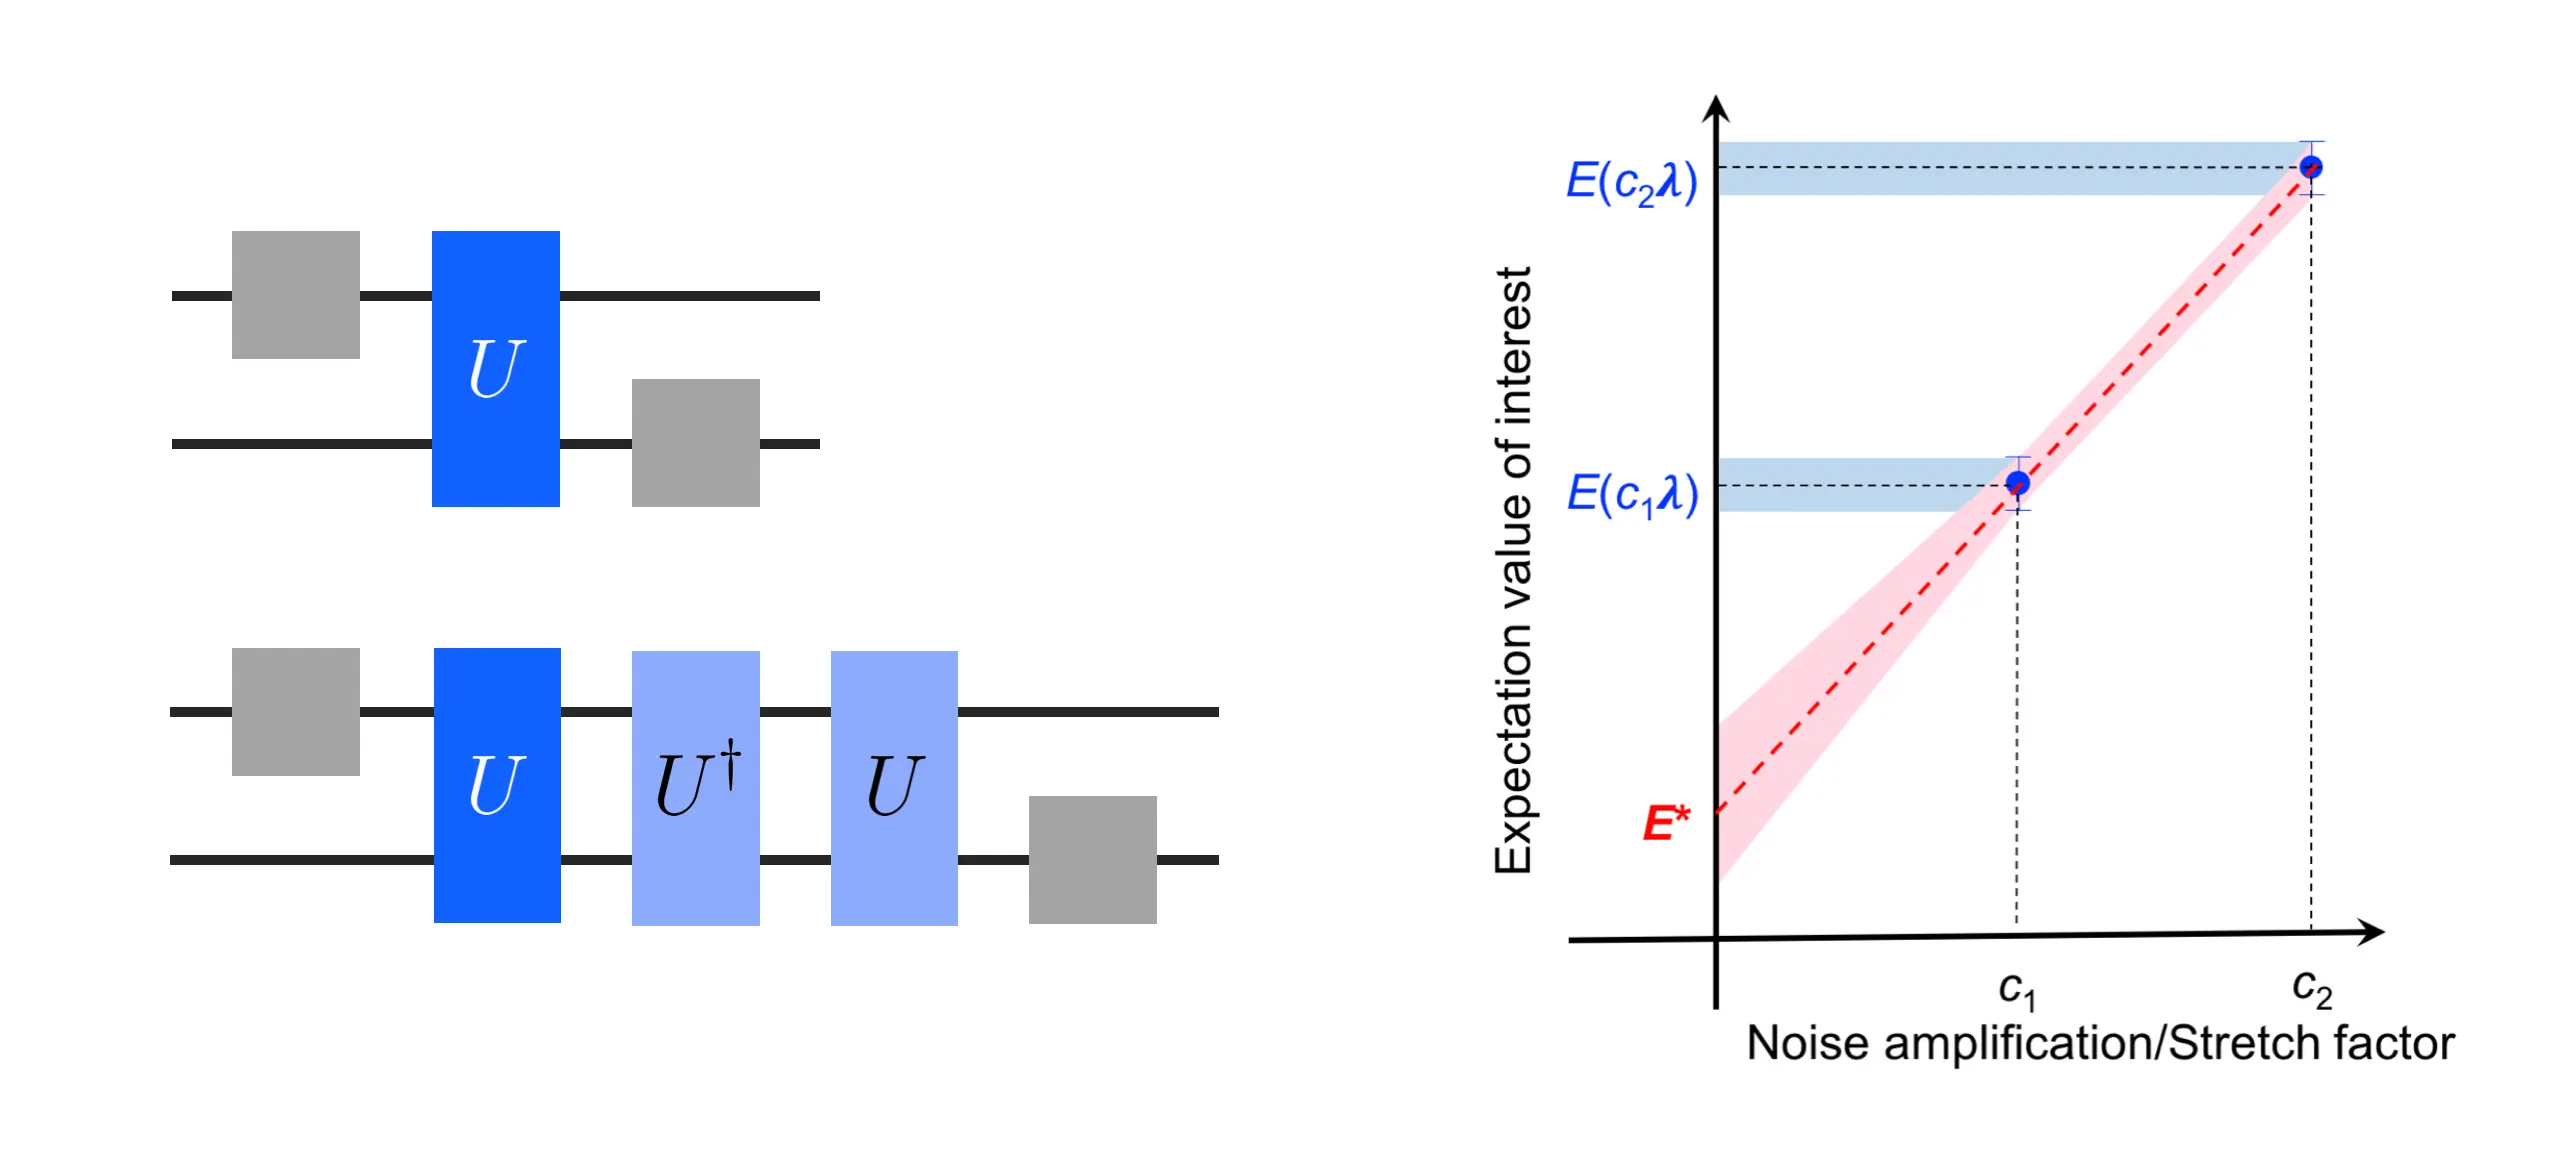



To understand how these different techniques will affect our computation we will submit five separate jobs, starting with no mitigation, and successively enabling various error suppression and mitigation options available in Qiskit Runtime.

Because these jobs can run independently of each other, you can use [batch mode](https://docs.quantum.ibm.com/run/run-jobs-batch) to allow Qiskit Runtime to optimize the timing of their execution. If you are an Open Plan user you will need to remove the batch line and run each job sequentially, as you can only have a maximum of 3 pending jobs at one time.

<div class="alert alert-block alert-danger">
NOTE: if you are an IBM Quantum Open Plan user you have an allocation of 10 minutes free QPU time per month to run experiments on real IBM quantum computers. The following code cell is estimated to consume 8 minutes of QPU time. QPU time only refers to the time it takes to execute your jobs on the device, it does not include the time your job is waiting in the queue. If you do not wish to use up your QPU time you can skip the following cell and continue with the rest of the lab.
</div>

In [100]:
from qiskit_ibm_runtime import Batch, EstimatorV2 as Estimator

pub = (isa_circuit, isa_observable)

jobs = []

with Batch(backend=backend) as batch:
    estimator = Estimator(session=batch)
    # Set number of shots
    estimator.options.default_shots = 100_000
    # Disable runtime compilation and error mitigation
    estimator.options.optimization_level = 0
    estimator.options.resilience_level = 0

    # Run job with no error mitigation
    job0 = estimator.run([pub])
    jobs.append(job0)

    # Add dynamical decoupling (DD)
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XpXm"
    job1 = estimator.run([pub])
    jobs.append(job1)

    # Add readout error mitigation (DD + TREX)
    estimator.options.resilience.measure_mitigation = True
    job2 = estimator.run([pub])
    jobs.append(job2)

    # Add gate twirling (DD + TREX + Gate Twirling)
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"
    job3 = estimator.run([pub])
    jobs.append(job3)

    # Add zero-noise extrapolation (DD + TREX + Gate Twirling + ZNE)
    estimator.options.resilience.zne_mitigation = True
    estimator.options.resilience.zne.noise_factors = (1, 3, 5)
    estimator.options.resilience.zne.extrapolator = ("exponential", "linear")
    job4 = estimator.run([pub])
    jobs.append(job4)

### Step 4: Post-process and return results in classical format

Finally, you can analyze the data. Here you will retrieve the job results, extract the measured expectation values from them, and plot the values, including error bars of one standard deviation. If you were not able to run your jobs on real hardware skip this code cell and run the next one to use pre-run data.

In [109]:
# Retrieve the job results
results = [job.result() for job in jobs]

# Unpack the PUB results (there's only one PUB result in each job result)
pub_results = [result[0] for result in results]

# Unpack the expectation values and standard errors
expectation_vals = np.array([float(pub_result.data.evs) for pub_result in pub_results])
standard_errors = np.array([float(pub_result.data.stds) for pub_result in pub_results])

[0.96884    0.94432    0.95728422 0.95302621 0.99847486]
[0.00078326 0.00104048 0.00724242 0.00731261 0.01094247]


In [116]:
#uncomment this cell and run it to load pre-saved data instead of data from the real hardware
# expectation_vals = [0.86884, 0.84432, 0.85728422, 0.95302621, 0.99847486]
# standard_errors = [0.00078326, 0.00104048, 0.00724242, 0.00731261, 0.01094247]

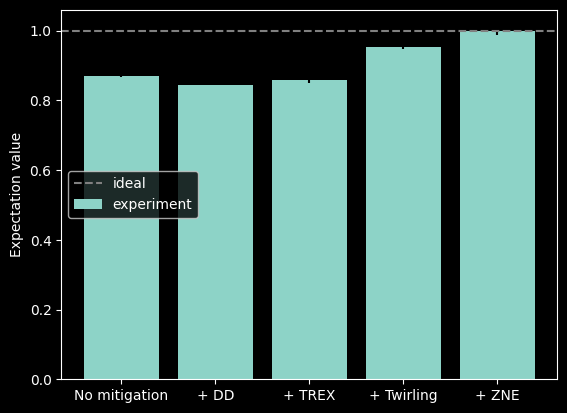

In [117]:
# Plot the expectation values
fig, ax = plt.subplots()
labels = ["No mitigation", "+ DD", "+ TREX", "+ Twirling", "+ ZNE"]
ax.bar(range(len(labels)), expectation_vals, yerr=standard_errors, label="experiment")
ax.axhline(y=1.0, color="gray", linestyle="--", label="ideal")
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_ylabel("Expectation value")
ax.legend(loc="center left")

plt.show()

From the results we can notice the following:
* The addition of dynamical decoupling might have worsened performance. This is not surprising, because the circuit is very dense. Dynamical decoupling is primarily useful when there are large gaps in the circuit during which qubits sit idle without gates being applied to them. When these gaps are not present, dynamical decoupling is not effective, and can actually worsen performance due to errors in the dynamical decoupling pulses themselves.
* With zero-noise extrapolation, the result is very close to the ideal result. This demonstrates the power of the ZNE technique!
